# **<h3 align="center">Machine Learning - Project</h3>**
## **<h3 align="center">4. Level 1 Classification</h3>**
### **<h3 align="center">Group 30 - Project</h3>**


### Group Members
| Name              | Email                        | Student ID |
|-------------------|------------------------------|------------|
| Alexandra Pinto   | 20211599@novaims.unl.pt      | 20211599   |
| Gonçalo Peres     | 20211625@novaims.unl.pt      | 20211625   |
| Leonor Mira       | 20240658@novaims.unl.pt      | 20240658   |
| Miguel Natário    | 20240498@novaims.unl.pt      | 20240498   |
| Nuno Bernardino   | 20211546@novaims.unl.pt      | 20211546   |



---

### **4. Level 1 Classification Notebook**
**Description:**
In this notebook, we will build and evaluate the **Level 1 Binary Classification model**, which separates the data into:
- Cases belonging to the two most common classes (e.g., **2 - NON-COMP** and **4 - TEMPORARY**).
- Cases classified as “**Other**” (all remaining classes).

Key steps include:
- Loading the **preprocessed dataset** created in Notebook 1.
- **Feature selection:** Identify features most relevant to this binary classification task.
- **Model training:** Train a binary classification model to distinguish between the "Common" and "Other" categories.
- **Evaluation:** Assess the performance of the Level 1 model using metrics like accuracy, precision, and recall.
- **Output:** Save predictions to pass data into the next stages (Level 2 Binary and Level 2 Multi-Class models).

This notebook ensures that data is efficiently routed into the appropriate paths for the subsequent levels.

---


## Table of Contents
* [1. Import the Libraries](#chapter1)
* [2. Load and Prepare Datasets](#chapter2)
* [3. Setting the Target](#chapter3)
* [4. Feature Selection](#chapter4)
    * [4.1. Scaling the Data](#section_4_1)  
    * [4.2. Numerical Features](#section_4_2) 
        * [4.2.1. Spearman and Pearson correlation matrix](#sub_section_4_2_1)
        * [4.2.2. LASSO Regression](#sub_section_4_2_2)
        * [4.2.3. Recursive Feature Elimination - RFE](#sub_section_4_2_3)
        * [4.2.4. Feature Importance - Decision Tree](#sub_section_4_2_4)
        * [4.2.5. Feature Importance - Random Forest](#sub_section_4_2_5)
    * [4.3. Categorical Features](#section_4_3) 
    * [4.4. Final Features](#section_4_3)
* [5. Modelling](#chapter5)
* [6. Loading the results](#chapter6)


# 1. Import the Libraries 📚<a class="anchor" id="chapter1"></a>

In [2]:
# --- Standard Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import zipfile


# --- Scikit-Learn Modules for Data Partitioning and Preprocessing ---
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import BaggingClassifier


# --- Feature Selection Methods ---
# Filter Methods
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn.feature_selection import mutual_info_classif, chi2, SelectKBest

# Wrapper Methods
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Embedded Methods
from sklearn.linear_model import LassoCV

# --- Evaluation Metrics ---
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from xgboost import XGBClassifier


# --- Warnings ---
import warnings
warnings.filterwarnings('ignore')




from utils import plot_importance, cor_heatmap, find_optimal_features_with_rfe, compare_rf_feature_importances,compare_feature_importances, select_high_score_features_chi2_no_model,select_high_score_features_MIC, metrics



# 2. Load and Prepare Datasets 📁<a class="anchor" id="chapter2"></a>

Now that we preprocessed the dataset in notebook 1. Preprocessing and Feature Engineering we will upload those datasets

In [3]:
#Import the datasets
X_train = pd.read_csv("../processed_datasets/X_train_model.csv", index_col="Claim Identifier")
X_val = pd.read_csv("../processed_datasets/X_val_model.csv", index_col="Claim Identifier")
df_test = pd.read_csv("../processed_datasets/df_test_model.csv", index_col="Claim Identifier")

In [4]:
X_train.head(5)

,Age at Injury,Attorney/Representative,Average Weekly Wage,Birth Year,Carrier Name,Carrier Type,County of Injury,COVID-19 Indicator,District Name,Gender,...,promptness_C2_category,promptness_C3_category,Zip_Code_Simplified,Carrier Type Merged,Carrier_Name_Simplified,Body_Part_Category,Injury_Nature_Category,Injury_Cause_Category,Industry Risk,Salary_Per_Dependent
Claim Identifier,,,,,,,,,,,,,,,,,,,,,
6099734,67,1.0,839,1955,INDEMNITY INS. OF N AMERICA,PRIVATE,NASSAU,0.0,NYC,M,...,Between 1 and 2 weeks,1 to 3 months,11550.0,PRIVATE,INDEMNITY INS. OF N AMERICA,Lower Extremities,Specific Injury,"Fall, Slip, or Trip",Medium Risk,839.0
5796182,30,0.0,150,1991,SAFETY NATIONAL CASUALTY CORP,PRIVATE,ORANGE,0.0,ALBANY,F,...,Until 1 week,Form Not Received,OTHER,PRIVATE,SAFETY NATIONAL CASUALTY CORP,Lower Extremities,Specific Injury,"Caught In, Under, or Between",Medium Risk,37.5
6128237,58,0.0,2261,1964,AMERICAN ZURICH INSURANCE CO,PRIVATE,OTSEGO,0.0,BINGHAMTON,M,...,Until 1 week,Form Not Received,OTHER,PRIVATE,AMERICAN ZURICH INSURANCE CO,Trunk,Specific Injury,"Cut, Puncture, Scrape",Medium Risk,1130.5
5394501,55,0.0,1227,1964,NEW YORK BLACK CAR OPERATORS',SELF PRIVATE,BRONX,0.0,NYC,M,...,3 to 6 months,3 to 6 months,OTHER,SELF PRIVATE,NEW YORK BLACK CAR OPERATORS',Multiple Body Parts,Specific Injury,Motor Vehicle,High Risk,613.5
5452763,25,0.0,1061,1995,STATE INSURANCE FUND,SIF,ALBANY,0.0,ALBANY,F,...,Until 1 week,Form Not Received,12306.0,SIF,STATE INSURANCE FUND,Upper Extremities,Specific Injury,Struck or Injured by,Low Risk,1061.0


In [5]:
# Load the arrays
y_train = np.load("../processed_datasets/y_train_preprocessed.npy", allow_pickle=True)
y_val =  np.load("../processed_datasets/y_train_preprocessed.npy", allow_pickle=True)

# 3. Setting the Target <a class="anchor" id="chapter3"></a>

In this section, we will analyze the distribution of the target variable to better understand its composition. This step is crucial for determining how to split the target into the two categories needed for the first level of the hierarchical classification: identifying the most common classes versus the "Other" category.

In [6]:
# Convert to Pandas Series and get value counts
y_train_series = pd.Series(y_train)
y_train_series.value_counts()

1    232862
3    118805
2     55125
4     38624
0      9980
5      3369
7       376
6        78
Name: count, dtype: int64

In [7]:
# Create a mapping where 2. NON-COMP and 4. TEMPORARY are mapped to new targets
def map_to_majority_minority(y):
    """
    Map the original targets to new categories:
    - '2. NON-COMP' and '4. TEMPORARY' -> 'Majority Target'
    - All other classes -> 'Minority Target'
    """
    return np.where(np.isin(y, ['2. NON-COMP', '4. TEMPORARY']), 'Majority Target', 'Minority Target')

# Apply the mapping to y_train and y_val
y_train_mapped = map_to_majority_minority(y_train)
y_val_mapped = map_to_majority_minority(y_val)

# Ensure the original y_train and y_val are preserved
print("Original y_train classes:", np.unique(y_train))
print("Mapped y_train classes:", np.unique(y_train_mapped))
print("Mapped y_val classes:", np.unique(y_val_mapped))

Original y_train classes: [0 1 2 3 4 5 6 7]


Mapped y_train classes: ['Minority Target']
Mapped y_val classes: ['Minority Target']


In [8]:
# Convert to Pandas Series and get value counts
y_train_new_series = pd.Series(y_train_mapped)
y_train_new_series.value_counts()

Minority Target    459219
Name: count, dtype: int64

In [9]:
# Convert to Pandas Series and get value counts
y_val_new_series = pd.Series(y_val_mapped)
y_val_new_series.value_counts()

Minority Target    459219
Name: count, dtype: int64

#### __`Encoding the Target`__

In [10]:
# Create a LabelEncoder instance
encoder = LabelEncoder()

# Encode y_train_new and y_val_new
y_train_encoded = encoder.fit_transform(y_train_mapped)  # Fit and transform on y_train_mapped
y_val_encoded = encoder.transform(y_val_mapped)  # Only transform on y_train_mapped

In [11]:
# Verify that the target is encoded 
print(f'y_train encoded: {y_train_encoded}')
print(f'y_val encoded: {y_val_encoded}')

y_train encoded: [0 0 0 ... 0 0 0]
y_val encoded: [0 0 0 ... 0 0 0]


# 4. Feature Selection <a class="anchor" id="chapter4"></a>

The feature selection process involves summarizing the essential features in the dataset to help the model focus on the most relevant information. Here, we assess the categorical and numerical variables in `X_train_processed` by examining unique values, descriptive statistics, and verifying the correctness of categorical bins and continuous feature distributions.

The `X_train_processed.describe(include='O').T` command provides an overview of the categorical features in the dataset, displaying the count, unique values, top (most frequent) category, and its frequency. This summary helps us understand the distribution and cardinality of each categorical feature, which is essential for feature selection and preprocessing.

#### Descriptive Statistics for Categorical Features

In [12]:
# Displaying descriptive statistics for categorical features in the training dataset
X_train.describe(include='O').T

,count,unique,top,freq
Carrier Name,459219,1996,STATE INSURANCE FUND,88862
Carrier Type,459219,8,PRIVATE,228492
County of Injury,459219,63,SUFFOLK,48468
District Name,459219,8,NYC,216798
Gender,459219,3,M,268315
Medical Fee Region,459219,5,IV,212825
Zip Code,459219.0,10608.0,11236.0,4492.0
Carrier_District_Interaction,459219,53,PRIVATE_NYC,105828
Income_Category,459219,5,Lower-Middle Income,120052
Age Group,459219,4,Young Adult,228893


This table provides insight into the number of unique categories within each feature, assisting in identifying high-cardinality features that may need simplification or encoding before modeling.

#### __`Analyses of the statistics`__

The next output explores the __`Income_Category`__ feature specifically, showing its categorical distribution across different income levels.

In [13]:
# Exploring the distribution of Income_Category
X_train['Income_Category'].value_counts()

Income_Category
Lower-Middle Income    120052
Low Income             114892
Middle Income          109513
Upper-Middle Income     73168
High Income             41594
Name: count, dtype: int64

The `Income_Category` feature categorizes the `Average Weekly Wage` into four levels:
- **Low Income**
- **Lower-Middle Income**
- **Upper-Middle Income**
- **High Income**

This feature provides a socioeconomic context for the claims, allowing the model to address income-based disparities effectively. After analyzing the table, we identified that the most prevalent income category is the Low-Middle Category, which could be important for both the model and our analys.

The next output explores the __`Age Group`__ feature specifically, showing its categorical distribution across different age groups.

In [14]:
# Exploring the distribution of Age Group
X_train['Age Group'].value_counts()

Age Group
Young Adult    228893
Middle Age     167736
Youth           46916
Senior          15674
Name: count, dtype: int64

Similarly, to the feature **Income Category**, the feature **Age Group** has a prevalence of the group **Young Adult** suggesting that the data focuses on individuals in the economically active age range or those more exposed to accidents/incidents, which is crucial for the model and our analysis.

### **-- xana comentario --> rever**

This feature allows the model to understand age-related variations in claims, which could influence the type and nature of injuries.

This structured feature selection summary provides insights into the main features, both categorical and numerical, used in the model. The focus on grouping, simplification, and categorization ensures the model captures the relevant patterns without unnecessary complexity.

#### Descriptive Statistics for Numerical Features

In [15]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Age at Injury,459219.0,42.884970,12.952508,5.000000,33.000000,42.00,53.0,82.00
Attorney/Representative,459219.0,0.316703,0.465191,0.000000,0.000000,0.00,1.0,1.00
Average Weekly Wage,459219.0,1238.327933,6582.516874,14.000000,876.000000,1211.00,1481.0,2828079.00
Birth Year,459219.0,1977.937736,13.068951,1919.000000,1968.000000,1979.00,1988.0,2006.00
COVID-19 Indicator,459219.0,0.048428,0.214669,0.000000,0.000000,0.00,0.0,1.00
IME-4 Count,459219.0,0.742171,1.924972,0.000000,0.000000,0.00,0.0,73.00
Industry Code,459219.0,58.701463,19.476792,11.000000,45.000000,61.00,62.0,92.00
WCIO Cause of Injury Code,459219.0,52.916915,27.008052,0.000000,29.000000,56.00,75.0,99.00
WCIO Nature of Injury Code,459219.0,39.930619,22.894421,0.000000,10.000000,49.00,52.0,91.00
WCIO Part Of Body Code,459219.0,46.634453,24.204028,0.000000,34.000000,42.00,55.0,101.00


These features provide comprehensive information across demographics, injury details, socioeconomics, and temporal aspects, making them well-suited to predicting claim outcomes.

#### Analysis of `Salary Per Dependent`

In [16]:
X_train['Salary_Per_Dependent'].value_counts()

Salary_Per_Dependent
174.000000     9736
243.600000     9611
406.000000     9593
609.000000     9568
304.500000     9563
               ... 
1620.333333       1
885.714286        1
722.333333        1
830.200000        1
954.750000        1
Name: count, Length: 15080, dtype: int64

### Feature Categories
The features have been organized into three main categories: **Categorical Features**, **Binary Features**, and **Discrete Features**. Each category represents a different data type or structure, allowing for tailored preprocessing steps and analysis.

In [17]:
X_train.columns

Index(['Age at Injury', 'Attorney/Representative', 'Average Weekly Wage',
       'Birth Year', 'Carrier Name', 'Carrier Type', 'County of Injury',
       'COVID-19 Indicator', 'District Name', 'Gender', 'IME-4 Count',
       'Industry Code', 'Medical Fee Region', 'WCIO Cause of Injury Code',
       'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'Zip Code',
       'Agreement Reached', 'Number of Dependents', 'Accident Year',
       'Carrier_District_Interaction', 'Income_Category',
       'Days_To_First_Hearing', 'Accident_Quarter', 'Accident_Year',
       'Accident Day', 'Accident on Weekend', 'Age Group',
       'promptness_category', 'promptness_C2_category',
       'promptness_C3_category', 'Zip_Code_Simplified', 'Carrier Type Merged',
       'Carrier_Name_Simplified', 'Body_Part_Category',
       'Injury_Nature_Category', 'Injury_Cause_Category', 'Industry Risk',
       'Salary_Per_Dependent'],
      dtype='object')

In [18]:
# Updating the feature categories with the new columns created
categorical_columns = ['Carrier Name', 'Carrier Type', 'County of Injury',
       'District Name', 'Gender', 'IME-4 Count',
       'Industry Code', 'Medical Fee Region', 'WCIO Cause of Injury Code',
       'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'Zip Code',
    'Carrier_District_Interaction',
       'Income_Category', 'Age Group',
       'promptness_category', 'promptness_C2_category','promptness_C3_category', 'Zip_Code_Simplified',
       'Carrier Type Merged', 'Carrier_Name_Simplified', 'Body_Part_Category',
       'Injury_Nature_Category', 'Injury_Cause_Category', 'Industry Risk',
]

binary_columns = [
    'Attorney/Representative', 'COVID-19 Indicator',
     'Accident on Weekend'
]

discrete_columns = [ 'Number of Dependents', 'IME-4 Count',
    'Accident_Quarter', 'Accident_Year', 'Accident Day'
]

continuous_columns = ['Days_To_First_Hearing','Average Weekly Wage','Age at Injury',
                      'Salary_Per_Dependent'
                      ]

# Printing the feature categories
print("Categorical Features:", categorical_columns)
print("Binary Features:", binary_columns)
print("Discrete Features:", discrete_columns)
print("Continuous Features:", continuous_columns)

Categorical Features: ['Carrier Name', 'Carrier Type', 'County of Injury', 'District Name', 'Gender', 'IME-4 Count', 'Industry Code', 'Medical Fee Region', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'Zip Code', 'Carrier_District_Interaction', 'Income_Category', 'Age Group', 'promptness_category', 'promptness_C2_category', 'promptness_C3_category', 'Zip_Code_Simplified', 'Carrier Type Merged', 'Carrier_Name_Simplified', 'Body_Part_Category', 'Injury_Nature_Category', 'Injury_Cause_Category', 'Industry Risk']
Binary Features: ['Attorney/Representative', 'COVID-19 Indicator', 'Accident on Weekend']
Discrete Features: ['Number of Dependents', 'IME-4 Count', 'Accident_Quarter', 'Accident_Year', 'Accident Day']
Continuous Features: ['Days_To_First_Hearing', 'Average Weekly Wage', 'Age at Injury', 'Salary_Per_Dependent']


## 4.1. Preparing Data</b> <a class="anchor" id="section_4_1"></a>
### Converting Discrete Columns to Integer
In this step, we ensure all discrete columns are converted to integer data types across the training, validation, and test datasets. This is crucial for consistent data handling and processing in subsequent steps.

In [19]:
# Convert discrete columns to integer
for column in discrete_columns:
    X_train[column] = X_train[column].astype(int)
    X_val[column] = X_val[column].astype(int)
    df_test[column] = df_test[column].astype(int)

### Scaling Features
We apply the RobustScaler to the discrete columns. RobustScaler is beneficial for data containing outliers, as it scales data based on the median and interquartile range. This helps normalize the distribution without being heavily affected by outliers. We also use the same scaler to transform validation and test data.

In [21]:
#scaling features
feat_scaler = MinMaxScaler()
X_train[discrete_columns + continuous_columns] = feat_scaler.fit_transform(X_train[discrete_columns + continuous_columns])

X_train_num_scaled = X_train[discrete_columns + continuous_columns]

#apply same transformation for val data
X_val[discrete_columns + continuous_columns] = feat_scaler.transform(X_val[discrete_columns + continuous_columns])

X_val_num_scaled = X_val[discrete_columns + continuous_columns]

#apply same transformation for test data
df_test[discrete_columns + continuous_columns] = feat_scaler.transform(df_test[discrete_columns + continuous_columns])
df_test_num_scaled = df_test[discrete_columns + continuous_columns]

#X_val, X_train
X_train_num_scaled.head(4)

,Number of Dependents,IME-4 Count,Accident_Quarter,Accident_Year,Accident Day,Days_To_First_Hearing,Average Weekly Wage,Age at Injury,Salary_Per_Dependent
Claim Identifier,,,,,,,,,
6099734,0.000000,0.054795,0.666667,0.983871,0.500000,0.010013,0.000292,0.805195,0.001182
5796182,0.500000,0.000000,0.666667,0.967742,0.833333,0.000305,0.000048,0.324675,0.000048
6128237,0.166667,0.000000,1.000000,0.983871,0.500000,0.000305,0.000795,0.688312,0.001594
5394501,0.166667,0.000000,0.666667,0.935484,0.833333,0.014776,0.000429,0.649351,0.000863


In [22]:
#scaling features
feat_scaler = RobustScaler()
X_train[discrete_columns + continuous_columns] = feat_scaler.fit_transform(X_train[discrete_columns + continuous_columns])

X_train_num_scaled = X_train[discrete_columns + continuous_columns]

#apply same transformation for val data
X_val[discrete_columns + continuous_columns] = feat_scaler.transform(X_val[discrete_columns + continuous_columns])

X_val_num_scaled = X_val[discrete_columns + continuous_columns]

#apply same transformation for test data
df_test[discrete_columns + continuous_columns] = feat_scaler.transform(df_test[discrete_columns + continuous_columns])
df_test_num_scaled = df_test[discrete_columns + continuous_columns]

#X_val, X_train
X_train_num_scaled.head(4)

,Number of Dependents,IME-4 Count,Accident_Quarter,Accident_Year,Accident Day,Days_To_First_Hearing,Average Weekly Wage,Age at Injury,Salary_Per_Dependent
Claim Identifier,,,,,,,,,
6099734,-0.75,0.054795,0.0,0.5,0.333333,2.208333,-0.614876,1.25,1.484131
5796182,0.00,0.000000,0.0,0.0,1.000000,0.000000,-1.753719,-0.60,-0.727921
6128237,-0.50,0.000000,0.5,0.5,0.333333,0.000000,1.735537,0.80,2.288638
5394501,-0.50,0.000000,0.0,-1.0,1.000000,3.291667,0.026446,0.65,0.861776


### Variance Check After Scaling
After scaling, we check the variance of each scaled feature to confirm that the features have been scaled properly. Lower variance after scaling indicates that data is normalized and less affected by magnitude differences.

In [28]:
# Check variance of scaled data
X_train_num_scaled.var()

Number of Dependents     0.111200
IME-4 Count              0.000698
Accident_Quarter         0.140603
Accident_Year            0.000853
Accident Day             0.092262
Days_To_First_Hearing    0.000249
Average Weekly Wage      0.000006
Age at Injury            0.040803
Salary_Per_Dependent     0.000008
dtype: float64

The output shows the variance of each discrete column in the scaled training set. These values help validate that the scaling process has achieved a consistent data distribution across features.

 ## 4.2. Numerical Features</b> <a class="anchor" id="section_4_2"></a>

 > ### 4.2.1. Spearman and Pearson correlation matrix <a class="anchor" id="sub_section_4_2_1"></a>

To better understand the relationships between numerical features, we generate Spearman and Pearson correlation matrices. Correlation matrices help identify linear and monotonic relationships between variables, which can be useful in feature selection and engineering.

##### Correlation Heatmap Function
The `cor_heatmap` function displays a heatmap of a given correlation matrix. We set various visual parameters to enhance readability:
- **figsize**: Sets the figure size.
- **cmap**: Chooses the color palette ('viridis').
- **mask**: Hides the upper triangle of the matrix for clarity.

In [29]:
from utils import cor_heatmap

#### Spearman Correlation Calculation and Plotting
Here, we calculate the Spearman correlation on the scaled numerical features and then plot the resulting matrix.

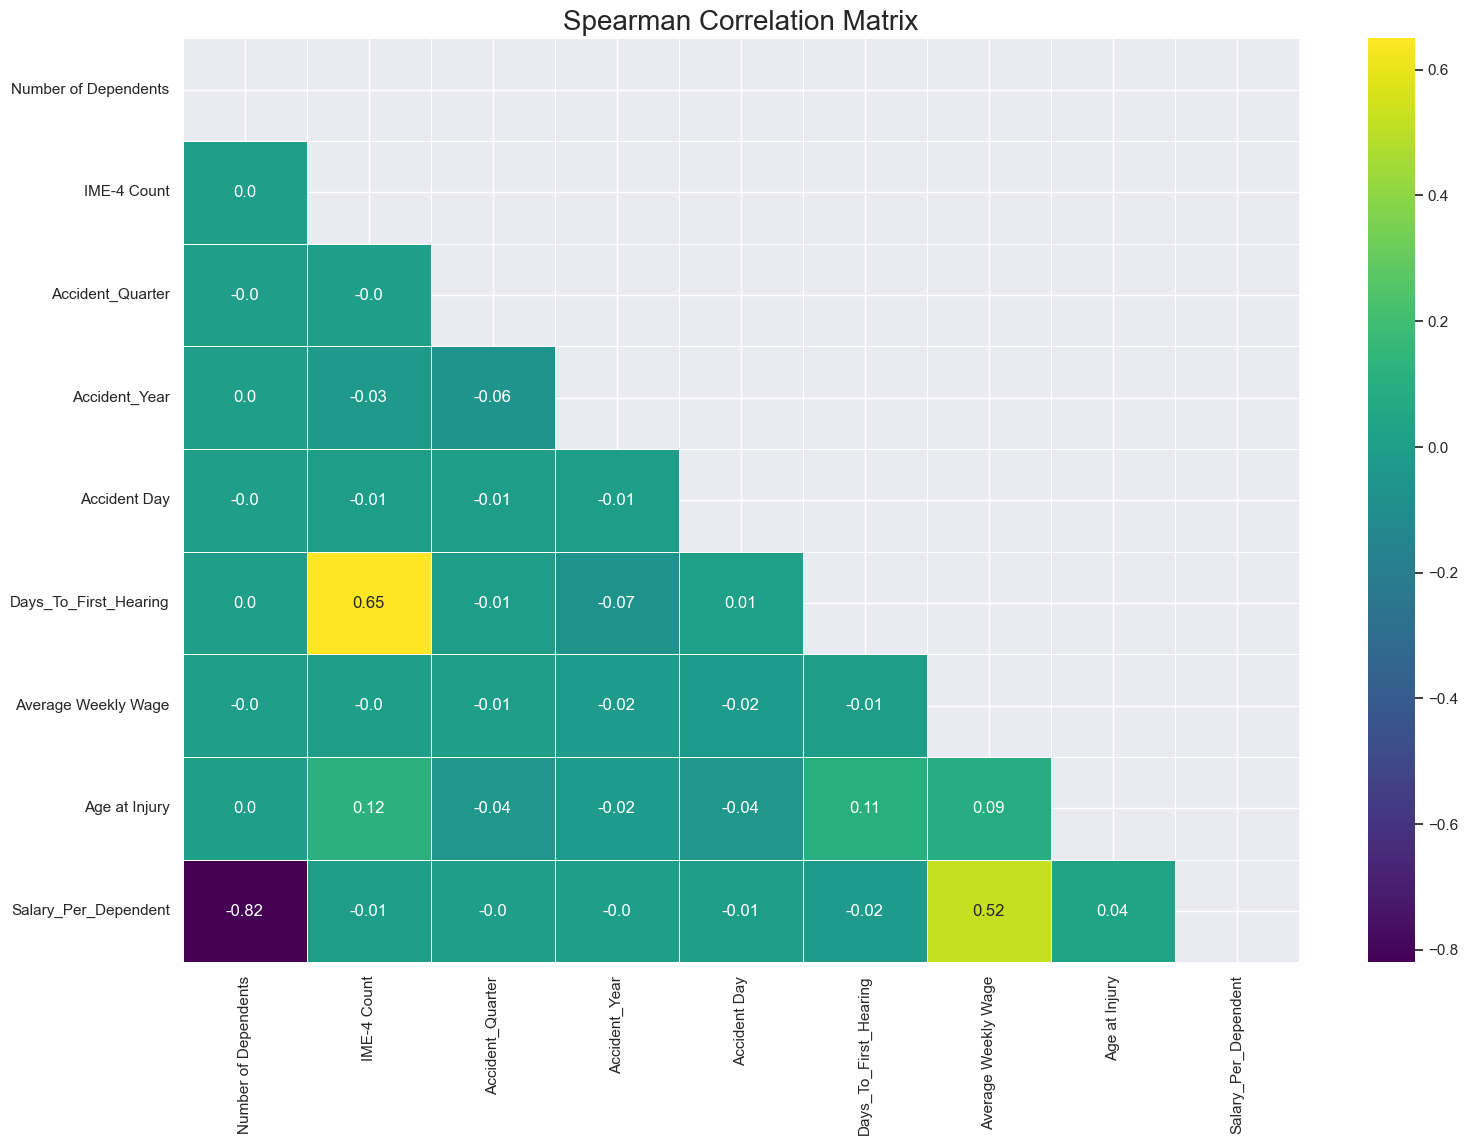

In [30]:
corr_data_numerical = X_train_num_scaled 
cor_spearman = corr_data_numerical.corr(method='spearman')

cor_heatmap(cor_spearman, 'Spearman')

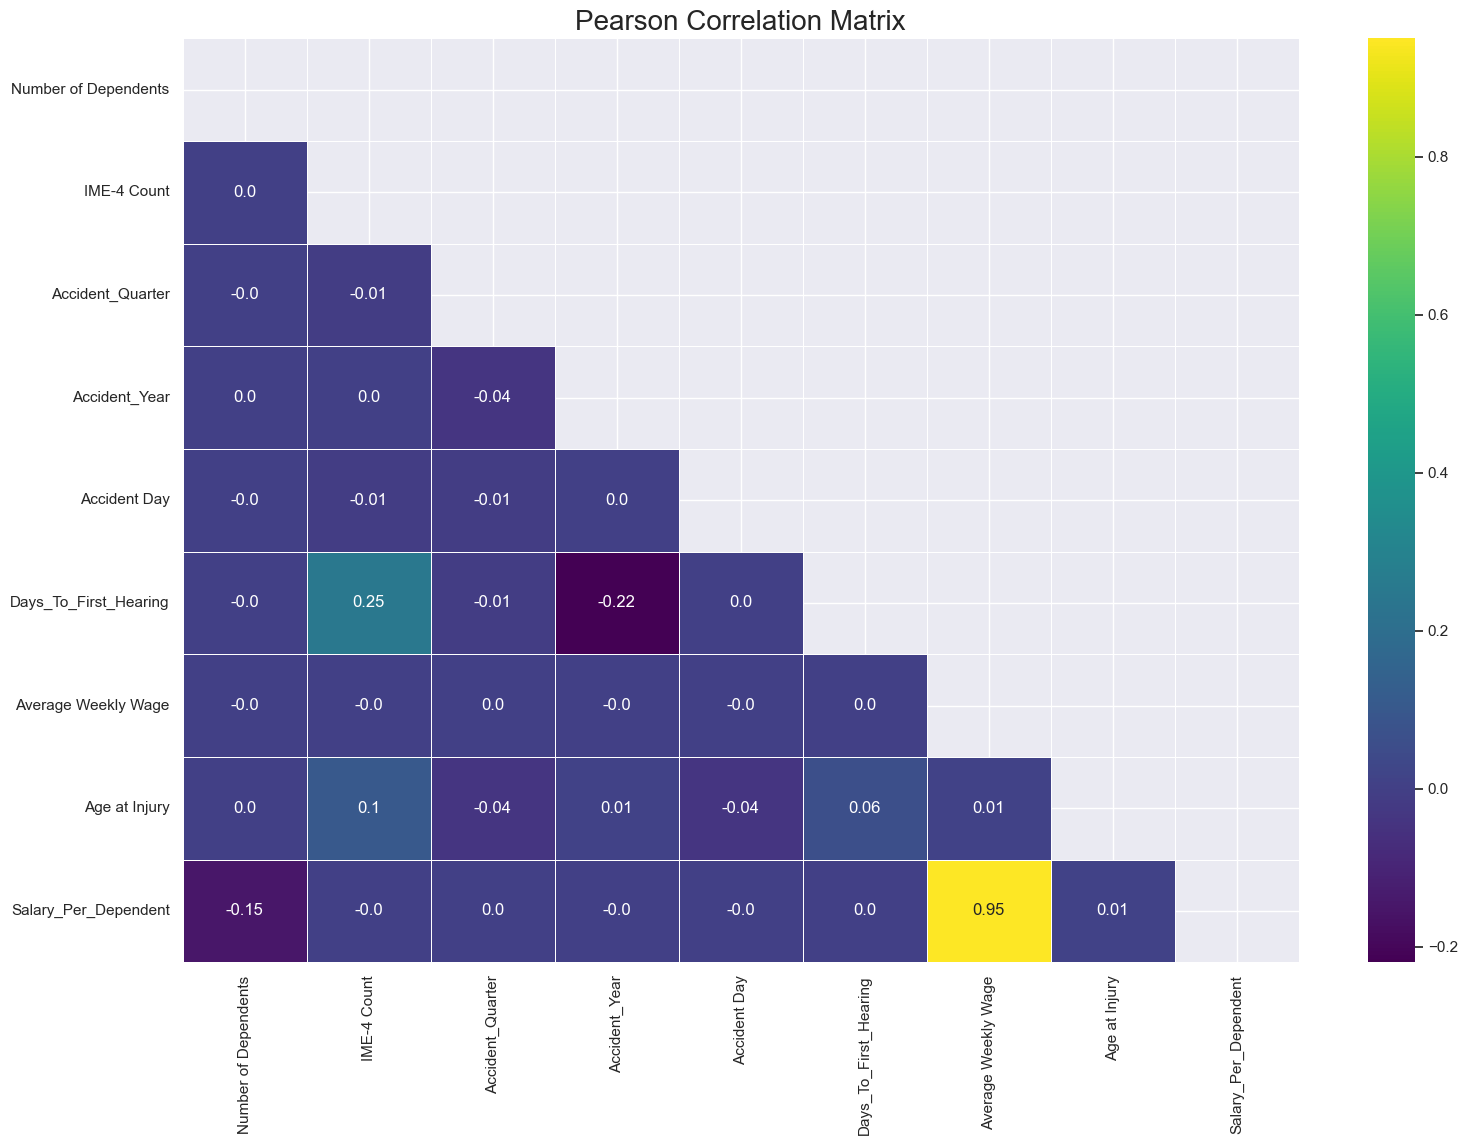

In [31]:
cor_pearson = corr_data_numerical.corr(method='pearson')

cor_heatmap(cor_pearson, 'Pearson')

> ### 4.2.2. LASSO Regression <a class="anchor" id="sub_section_4_2_2"></a>

 The LASSO (Least Absolute Shrinkage and Selection Operator) regression is used here for feature selection by fitting a model to the standardized dataset and analyzing the coefficients.

In [32]:
# Fit regression
reg = LassoCV().fit(X_train_num_scaled, y_train_encoded)
#get coefficients
coef = pd.Series(reg.coef_, index = X_train_num_scaled.columns)
# Sort coefficients to observe importance
coef.sort_values()

Accident_Quarter        -0.013479
Accident Day            -0.002988
Number of Dependents    -0.000233
Average Weekly Wage      0.000000
Age at Injury            0.099168
Accident_Year            0.373430
IME-4 Count              0.655242
Salary_Per_Dependent     0.805621
Days_To_First_Hearing    4.547687
dtype: float64

**Observations:**

The LASSO model assigns non-zero coefficients only to the features it considers important.

IME-4 Count has the highest positive coefficient, indicating a strong positive relationship with the target variable, as well as Days_To_First_Hearing


Accident Day and Accident Quarter have smaller negative coefficients, implying a weaker inverse relationship with the target.

Average Weekly Wage and Number of Dependents has close to zero impact, suggesting it may not be a significant predictor in the model.

In [33]:
from utils import plot_importance, cor_heatmap

This function generates a horizontal bar plot of the feature importance values derived from the LASSO model, helping to visualize which features are prioritized by the model.

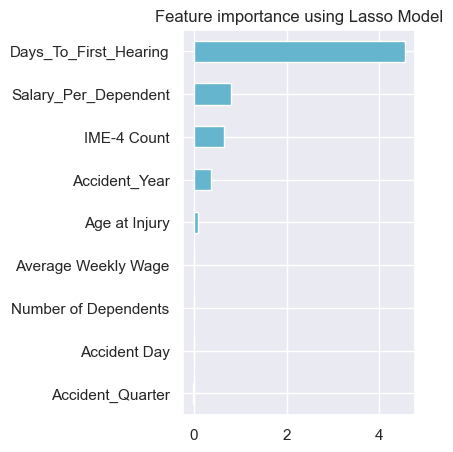

In [34]:
plot_importance(coef,'Lasso')

> ### 4.2.3. Recursive Feature Elimination - RFE <a class="anchor" id="sub_section_4_2_3"></a>

 RFE is employed here to further validate the important features as identified by LASSO. By sequentially removing the least important features, RFE helps to refine the feature set.

Observations:
The selected features after RFE likely overlap with those identified by LASSO, suggesting consistency in feature importance.
Using both LASSO and RFE provides a more robust feature selection by cross-validating the importance of individual features.

This block of code performs RFE to identify the best subset of features by iterating over a range of feature numbers. The code aims to maximize model performance on the validation set.

In [35]:
# RFE using Logistic Regression
model = LogisticRegression()


#Use the function defined in utils.py
best_features, best_score, scores = find_optimal_features_with_rfe(
    model, 
    X_train_num_scaled, 
    y_train_encoded, 
    X_val_num_scaled, 
    y_val_encoded,
    max_features=9
)


Optimum number of features: 1
F1 Macro Score with 1 features: 0.485586


**Observations:**

The loop evaluates models with 1 to 9 features, tracking the score for each.

The output indicates that 2 features yielded the highest validation f1_score score of 0.483851.

#### Applying RFE with the Optimal Number of Features
Once the optimal number of features is identified, the RFE model is finalized with this configuration.

In [36]:
#rfscv- to select 1st the number of features we should select
model = LogisticRegression()
rfe = RFE(estimator = model, n_features_to_select = 1)

In [37]:
X_rfe= rfe.fit_transform(X=X_train_num_scaled, y=y_train_encoded)

This shows the results of the feature selection process, listing the features selected by RFE. The code snippet confirms which features were selected as relevant by the RFE model and displays them in a boolean Series, where True indicates the feature was selected and False means it was not.

In [38]:
selected_features = pd.Series(rfe.support_, index = X_train_num_scaled.columns)
selected_features

Number of Dependents     False
IME-4 Count              False
Accident_Quarter         False
Accident_Year            False
Accident Day             False
Days_To_First_Hearing     True
Average Weekly Wage      False
Age at Injury            False
Salary_Per_Dependent     False
dtype: bool

> ### 4.2.4. Feature Importance - Decision Tree <a class="anchor" id="sub_section_4_2_4"></a>


In [39]:
from utils import compare_feature_importances


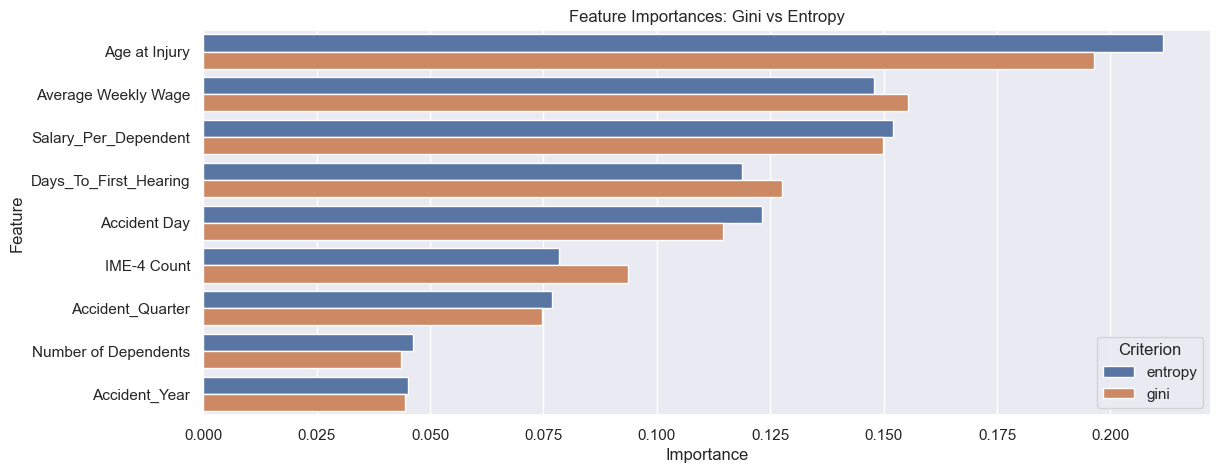

       gini   entropy                   col
0  0.043508  0.046271  Number of Dependents
1  0.093695  0.078422           IME-4 Count
2  0.074598  0.076798      Accident_Quarter
3  0.044473  0.045160         Accident_Year
4  0.114679  0.123196          Accident Day


In [40]:
# Call the function with your training data
zippy = compare_feature_importances(X_train_num_scaled, y_train_encoded)

# Access the DataFrame for further analysis if needed
print(zippy.head())

> ### 4.2.5. Feature Importance - Random Forest <a class="anchor" id="sub_section_4_2_5"></a>

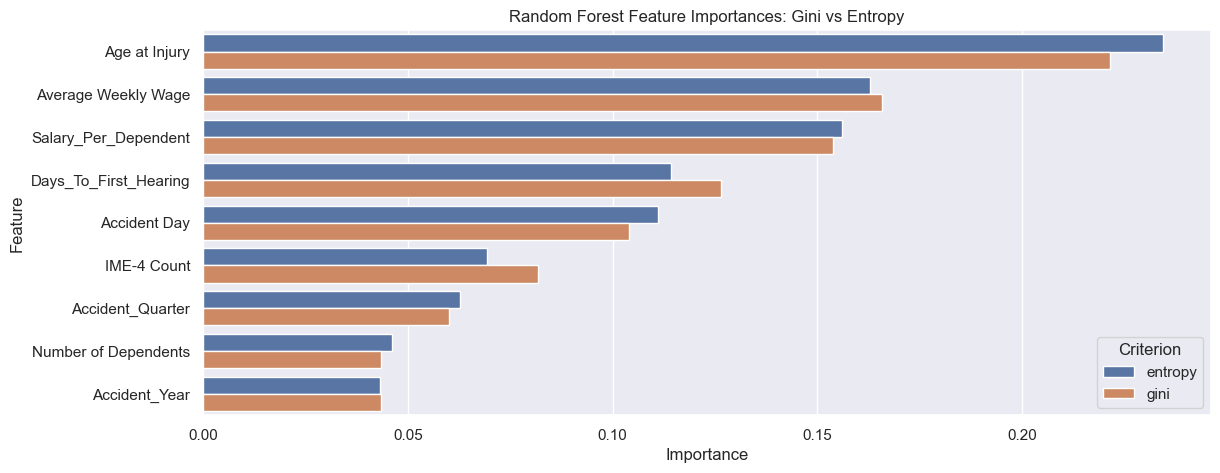

       gini   entropy                   col
0  0.043457  0.046221  Number of Dependents
1  0.081848  0.069238           IME-4 Count
2  0.059974  0.062661      Accident_Quarter
3  0.043436  0.043287         Accident_Year
4  0.103987  0.111115          Accident Day


In [41]:
# Call the function with your training data
importances = compare_rf_feature_importances(X_train_num_scaled, y_train_encoded)

# Access the DataFrame for further analysis if needed
print(importances.head())

## 4.3. Categorical Features</b> <a class="anchor" id="section_4_3"></a>
Chi-squared and MIC for the categorical ones.

 > ### $\chi ^2$ Test for Independence <a class="anchor" id="sub_section_4_2_1"></a>

 We'll apply the Chi-squared test on categorical features to check for independence. This test is suitable for categorical data and helps identify features that have significant associations with the target variable.

In [42]:
binary_columns

['Attorney/Representative', 'COVID-19 Indicator', 'Accident on Weekend']

In [43]:
#To make sure that we keep the preprocessed dataset without the encoded columns
X_train_processed_copy = X_train.copy()
X_val_processed_copy = X_val.copy()
df_test_processed_copy = df_test.copy()

In [44]:
X_train_processed_copy.shape

(398994, 38)

In [45]:
X_val_processed_copy.shape

(172208, 38)

In [46]:
X_val_processed_copy.columns

Index(['Age at Injury', 'Attorney/Representative', 'Average Weekly Wage',
       'Birth Year', 'Carrier Name', 'Carrier Type', 'County of Injury',
       'COVID-19 Indicator', 'District Name', 'Gender', 'IME-4 Count',
       'Industry Code', 'Medical Fee Region', 'WCIO Cause of Injury Code',
       'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'Zip Code',
       'Number of Dependents', 'Category Combination',
       'Carrier_District_Interaction', 'Income_Category',
       'Days_To_First_Hearing', 'Accident_Quarter', 'Accident_Year',
       'Accident Day', 'Accident on Weekend', 'Age Group',
       'promptness_category', 'promptness_C2_category',
       'promptness_C3_category', 'Zip_Code_Simplified', 'Carrier Type Merged',
       'Carrier_Name_Simplified', 'Body_Part_Category',
       'Injury_Nature_Category', 'Injury_Cause_Category', 'Industry Risk',
       'Salary_Per_Dependent'],
      dtype='object')

### Approach: Encoding Categorical Features with LabelEncoder, OneHotEncoder and Frequency encoder
As our second approach we decided to perform different type of encoding according with each categorical variable. For ordinal features (those with an inherent order like age groups), Label Encoding is applied to assign each category a unique numerical value. For nominal features with low cardinality (few unique values), One-Hot Encoding is used to create binary columns representing each category. For high-cardinality features (many unique values like zip codes), Frequency Encoding is applied to convert categories to their frequency of occurrence, reducing dimensionality without introducing too many columns.

These encoding methods are used to properly represent categorical features in a numerical format while considering their characteristics (order or cardinality), which helps models interpret them effectively.

In [47]:
X_train_processed_copy['District Name'].value_counts()

District Name
NYC           188402
ALBANY         59860
HAUPPAUGE      42054
BUFFALO        31613
SYRACUSE       31149
ROCHESTER      28041
BINGHAMTON     15171
STATEWIDE       2704
Name: count, dtype: int64

In [48]:
# Example columns to encode
ordinal_features = ['promptness_category', 'promptness_C2_category','promptness_C3_category', 'Age Group', 'Income_Category', 'Industry Risk']
low_cardinality_cols = ['Gender', 'Medical Fee Region','Body_Part_Category',
       'Injury_Nature_Category', 'Injury_Cause_Category']
high_cardinality_cols = ['Carrier_Name_Simplified', 'Zip_Code_Simplified', 'Industry Code', 'County of Injury', 'Carrier Type Merged',
                         'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code','Carrier_District_Interaction', 'District Name']


# Check for NaN or nulls
print(X_val_processed_copy[ordinal_features + low_cardinality_cols + high_cardinality_cols].isnull().sum())

promptness_category               1817
promptness_C2_category            1175
promptness_C3_category            1127
Age Group                            0
Income_Category                      0
Industry Risk                        0
Gender                               0
Medical Fee Region                   0
Body_Part_Category              172208
Injury_Nature_Category            4701
Injury_Cause_Category             4695
Carrier_Name_Simplified              0
Zip_Code_Simplified                  0
Industry Code                        0
County of Injury                     0
Carrier Type Merged                  0
WCIO Cause of Injury Code            0
WCIO Nature of Injury Code           0
WCIO Part Of Body Code               0
Carrier_District_Interaction         0
District Name                        0
dtype: int64


In [49]:
#por agora antes de descobrir o erro

# Substituir os valores NaN pela moda de cada coluna

# Substituir NaNs por moda no conjunto de treino, validação e teste
for col in ordinal_features + low_cardinality_cols + high_cardinality_cols:
    # Calcular a moda da coluna no conjunto de treino
    moda = X_train_processed_copy[col].mode()[0]
    
    # Substituir NaNs nos três conjuntos de dados pela moda calculada
    X_train_processed_copy[col] = X_train_processed_copy[col].fillna(moda)
    X_val_processed_copy[col] = X_val_processed_copy[col].fillna(moda)
    df_test_processed_copy[col] = df_test_processed_copy[col].fillna(moda)

# Verificar se ainda existem valores ausentes
print(X_train_processed_copy.isnull().sum())
print(X_val_processed_copy.isnull().sum())
print(df_test_processed_copy.isnull().sum())

Age at Injury                   0
Attorney/Representative         0
Average Weekly Wage             0
Birth Year                      0
Carrier Name                    0
Carrier Type                    0
County of Injury                0
COVID-19 Indicator              0
District Name                   0
Gender                          0
IME-4 Count                     0
Industry Code                   0
Medical Fee Region              0
WCIO Cause of Injury Code       0
WCIO Nature of Injury Code      0
WCIO Part Of Body Code          0
Zip Code                        1
Number of Dependents            0
Category Combination            0
Carrier_District_Interaction    0
Income_Category                 0
Days_To_First_Hearing           0
Accident_Quarter                0
Accident_Year                   0
Accident Day                    0
Accident on Weekend             0
Age Group                       0
promptness_category             0
promptness_C2_category          0
promptness_C3_

In [50]:
df_test_processed_copy['Industry Risk'].value_counts()

Industry Risk
Unknown Risk    293128
High Risk        85111
Medium Risk       9736
Name: count, dtype: int64

In [51]:
# #por agoraaaaaaaaaa

# # Obter o valor mais frequente (moda) da coluna 'Industry Risk' no conjunto de treino
# most_frequent_value = X_train_processed_copy['Industry Risk'].mode()[0]

# # Substituir 'Unknown Risk' por esse valor no conjunto de teste
# df_test_processed_copy['Industry Risk'] = df_test_processed_copy['Industry Risk'].replace('Unknown Risk', most_frequent_value)

In [52]:
# Sum all the NaN values in the datasets
missing_values_total = (
    X_train_processed_copy.isnull().sum().sum() +
    X_val_processed_copy.isnull().sum().sum() +
    df_test_processed_copy.isnull().sum().sum()
)

print(f"Total NaN values in all  the datasets: {missing_values_total}")

Total NaN values in all  the datasets: 1


In [53]:
#For now since the pre processing isnt finish lets replace nan by 0 the row tha has nan vlaues
X_train_processed_copy = X_train_processed_copy.fillna(0)


In [54]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
import pandas as pd

# Step 1: Ordinal Encode ordinal features (features with intrinsic order)
ordinal_encoder = OrdinalEncoder()
for col in ordinal_features:
    # Ensure input is a column from the DataFrame
    print(f"Processing ordinal feature: {col}")
    X_train_processed_copy[col] = ordinal_encoder.fit_transform(X_train_processed_copy[[col]])
    X_val_processed_copy[col] = ordinal_encoder.transform(X_val_processed_copy[[col]])
    df_test_processed_copy[col] = ordinal_encoder.transform(df_test_processed_copy[[col]])

# Step 2: One-Hot Encode low-cardinality nominal features
print("\nProcessing low-cardinality features for One-Hot Encoding...")
one_hot_encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')  # Ensure dense output

# Extract the subset of low-cardinality columns
low_cardinality_train = X_train_processed_copy[low_cardinality_cols]
low_cardinality_val = X_val_processed_copy[low_cardinality_cols]
low_cardinality_test = df_test_processed_copy[low_cardinality_cols]

# Apply One-Hot Encoding
one_hot_encoded_train = one_hot_encoder.fit_transform(low_cardinality_train)
one_hot_encoded_val = one_hot_encoder.transform(low_cardinality_val)
one_hot_encoded_test = one_hot_encoder.transform(low_cardinality_test)

# Verify the shapes
print("Shape of one-hot encoded train data:", one_hot_encoded_train.shape)
print("Shape of one-hot encoded val data:", one_hot_encoded_val.shape)
print("Shape of one-hot encoded test data:", one_hot_encoded_test.shape)

# Convert One-Hot Encoded arrays to DataFrames
feature_names = one_hot_encoder.get_feature_names_out(low_cardinality_cols)
one_hot_encoded_train_df = pd.DataFrame(one_hot_encoded_train, columns=feature_names, index=X_train_processed_copy.index)
one_hot_encoded_val_df = pd.DataFrame(one_hot_encoded_val, columns=feature_names, index=X_val_processed_copy.index)
one_hot_encoded_test_df = pd.DataFrame(one_hot_encoded_test, columns=feature_names, index=df_test_processed_copy.index)

# Concatenate the encoded columns with the original datasets
X_train_processed_copy = pd.concat([X_train_processed_copy, one_hot_encoded_train_df], axis=1)
X_val_processed_copy = pd.concat([X_val_processed_copy, one_hot_encoded_val_df], axis=1)
df_test_processed_copy = pd.concat([df_test_processed_copy, one_hot_encoded_test_df], axis=1)

# Drop original low-cardinality columns
X_train_processed_copy.drop(columns=low_cardinality_cols, inplace=True)
X_val_processed_copy.drop(columns=low_cardinality_cols, inplace=True)
df_test_processed_copy.drop(columns=low_cardinality_cols, inplace=True)

# Step 3: Frequency Encoding for high-cardinality nominal features
print("\nProcessing high-cardinality features for Frequency Encoding...")
for col in high_cardinality_cols:
    print(f"Encoding high-cardinality feature: {col}")
    # Frequency count based on the training data
    freq = X_train_processed_copy[col].value_counts()
    # Apply mapping to all datasets
    X_train_processed_copy[f"{col}_freq"] = X_train_processed_copy[col].map(freq).fillna(0)
    X_val_processed_copy[f"{col}_freq"] = X_val_processed_copy[col].map(freq).fillna(0)
    df_test_processed_copy[f"{col}_freq"] = df_test_processed_copy[col].map(freq).fillna(0)

# Drop original high-cardinality columns
X_train_processed_copy.drop(columns=high_cardinality_cols, inplace=True)
X_val_processed_copy.drop(columns=high_cardinality_cols, inplace=True)
df_test_processed_copy.drop(columns=high_cardinality_cols, inplace=True)

# Final datasets after encoding
X_train_final = X_train_processed_copy.copy()
X_val_final = X_val_processed_copy.copy()
X_test_final = df_test_processed_copy.copy()

# Summary
print("\nSummary of encoded datasets:")
print("Final X_train_final shape:", X_train_final.shape)
print("Final X_val_final shape:", X_val_final.shape)
print("Final X_test_final shape:", X_test_final.shape)


Processing ordinal feature: promptness_category
Processing ordinal feature: promptness_C2_category
Processing ordinal feature: promptness_C3_category
Processing ordinal feature: Age Group
Processing ordinal feature: Income_Category
Processing ordinal feature: Industry Risk

Processing low-cardinality features for One-Hot Encoding...
Shape of one-hot encoded train data: (398994, 25)
Shape of one-hot encoded val data: (172208, 25)
Shape of one-hot encoded test data: (387975, 25)

Processing high-cardinality features for Frequency Encoding...
Encoding high-cardinality feature: Carrier_Name_Simplified
Encoding high-cardinality feature: Zip_Code_Simplified
Encoding high-cardinality feature: Industry Code
Encoding high-cardinality feature: County of Injury
Encoding high-cardinality feature: Carrier Type Merged
Encoding high-cardinality feature: WCIO Cause of Injury Code
Encoding high-cardinality feature: WCIO Nature of Injury Code
Encoding high-cardinality feature: WCIO Part Of Body Code
Enc

### Why Are There Missing Values (NaN) in Validation and Test Sets?

During the encoding process, missing values (NaN) may appear in the validation and test sets because certain categories that exist in these sets might not be present in the training set. For instance, during frequency encoding, if a category exists only in the validation or test set but not in the training set, it will result in missing values when encoding those rows.

To address this, we can fill these missing values with a placeholder such as `0`, ensuring consistent feature representation across all datasets, for now. For next deliverable we will try to implement better approaches.

In [55]:
# Summing all the NaN values in the datasets
missing_values_total = (
    X_train_final.isnull().sum().sum() +
    X_val_final.isnull().sum().sum() +
    X_test_final.isnull().sum().sum()
)

print(f"Total NaN sum: {missing_values_total}")

Total NaN sum: 0


In [56]:
#Prepare final dataset for MIC and χ² analysis
# Use only the encoded features for the MIC and chi-squared tests
mic_chi2_features = binary_columns + ordinal_features + list(one_hot_encoded_train_df.columns) + [f"{col}_freq" for col in high_cardinality_cols]
X_train_mic_chi2 = X_train_final[mic_chi2_features]

In [57]:
len(X_train_mic_chi2.columns)

44

In [58]:
X_train_mic_chi2.columns

Index(['Attorney/Representative', 'COVID-19 Indicator', 'Accident on Weekend',
       'promptness_category', 'promptness_C2_category',
       'promptness_C3_category', 'Age Group', 'Income_Category',
       'Industry Risk', 'Gender_M', 'Gender_U', 'Medical Fee Region_II',
       'Medical Fee Region_III', 'Medical Fee Region_IV',
       'Medical Fee Region_UK', 'Body_Part_Category_Lower Extremities',
       'Body_Part_Category_Multiple Body Parts', 'Body_Part_Category_Neck',
       'Body_Part_Category_NonClassificable', 'Body_Part_Category_Trunk',
       'Body_Part_Category_Upper Extremities',
       'Injury_Nature_Category_Multiple Injuries',
       'Injury_Nature_Category_Occupational Disease or Cumulative Injury',
       'Injury_Nature_Category_Specific Injury',
       'Injury_Cause_Category_COVID-19 Injury',
       'Injury_Cause_Category_Caught In, Under, or Between',
       'Injury_Cause_Category_Cut, Puncture, Scrape',
       'Injury_Cause_Category_Fall, Slip, or Trip',
       'In

#### Chi-Squared Test for Feature Selection
The Chi-squared test helps us identify the most relevant categorical and binary features by evaluating their independence with the target variable. In this analysis, we set a threshold to keep the 25 most relevant features.

In [59]:
from utils import select_high_score_features_chi2_no_model


In [60]:
# Example usage
high_score_features_chi2, scores = select_high_score_features_chi2_no_model(
    X_train_mic_chi2, 
    y_train_encoded, 
    threshold=25
)

Top 25 features based on Chi-square scores: ['Carrier Type Merged_freq', 'WCIO Nature of Injury Code_freq', 'Zip_Code_Simplified_freq', 'Carrier_District_Interaction_freq', 'County of Injury_freq', 'Industry Code_freq', 'WCIO Part Of Body Code_freq', 'Carrier_Name_Simplified_freq', 'WCIO Cause of Injury Code_freq', 'District Name_freq', 'Attorney/Representative', 'promptness_C3_category', 'promptness_C2_category', 'Injury_Cause_Category_Strain or Injury By', 'promptness_category', 'Industry Risk', 'COVID-19 Indicator', 'Body_Part_Category_Trunk', 'Injury_Cause_Category_Cut, Puncture, Scrape', 'Injury_Cause_Category_COVID-19 Injury', 'Income_Category', 'Age Group', 'Body_Part_Category_NonClassificable', 'Body_Part_Category_Multiple Body Parts', 'Body_Part_Category_Upper Extremities']
Corresponding Chi-square scores: [61888218.505550124, 24440725.680518415, 15778724.944816345, 14925350.963330219, 7883300.29973166, 6493992.496444894, 6452255.864445573, 609274.4255401233, 440912.1710841229

In [61]:
high_score_features_chi2

['Carrier Type Merged_freq',
 'WCIO Nature of Injury Code_freq',
 'Zip_Code_Simplified_freq',
 'Carrier_District_Interaction_freq',
 'County of Injury_freq',
 'Industry Code_freq',
 'WCIO Part Of Body Code_freq',
 'Carrier_Name_Simplified_freq',
 'WCIO Cause of Injury Code_freq',
 'District Name_freq',
 'Attorney/Representative',
 'promptness_C3_category',
 'promptness_C2_category',
 'Injury_Cause_Category_Strain or Injury By',
 'promptness_category',
 'Industry Risk',
 'COVID-19 Indicator',
 'Body_Part_Category_Trunk',
 'Injury_Cause_Category_Cut, Puncture, Scrape',
 'Injury_Cause_Category_COVID-19 Injury',
 'Income_Category',
 'Age Group',
 'Body_Part_Category_NonClassificable',
 'Body_Part_Category_Multiple Body Parts',
 'Body_Part_Category_Upper Extremities']

> ### Mutual Information Criterion (MIC) for Feature Selection <a class="anchor" id="sub_section_4_2_2"></a>

The Mutual Information Criterion is used to measure the dependence between each feature and the target variable. By setting a threshold, we retain only the most relevant features.

In [62]:
from utils import select_high_score_features_MIC


In [63]:
# Example usage
high_score_features_MIC, scores_MIC = select_high_score_features_MIC(
    X_train_mic_chi2, 
    y_train_mapped, 
    threshold=25, 
    random_state=42)

Top 25 features based on MIC scores: ['Industry Risk', 'promptness_C3_category', 'Zip_Code_Simplified_freq', 'Attorney/Representative', 'Gender_M', 'Injury_Nature_Category_Specific Injury', 'Medical Fee Region_IV', 'Carrier_Name_Simplified_freq', 'Carrier Type Merged_freq', 'District Name_freq', 'WCIO Nature of Injury Code_freq', 'promptness_C2_category', 'promptness_category', 'WCIO Part Of Body Code_freq', 'Industry Code_freq', 'Age Group', 'Carrier_District_Interaction_freq', 'Body_Part_Category_Upper Extremities', 'WCIO Cause of Injury Code_freq', 'Income_Category', 'Injury_Cause_Category_Strain or Injury By', 'Body_Part_Category_Trunk', 'County of Injury_freq', 'Body_Part_Category_Lower Extremities', 'Injury_Cause_Category_Struck or Injured by']
Corresponding MIC scores: [0.06149981875714294, 0.060369638646895485, 0.057308507078118076, 0.05488134440861736, 0.04808664318150346, 0.043890422286378294, 0.03632876009342767, 0.03567958128569915, 0.03191127077523115, 0.0290367402111813, 

### Intersection of Selected Features by Chi-squared and MIC
To identify the most relevant categorical features, we take the intersection of features selected by both Chi-squared and MIC methods.

In [64]:
# Find common features between Chi-squared and MIC selections
common_categorical_features = list(set(high_score_features_chi2).intersection(set(high_score_features_MIC)))
features_selected = common_categorical_features  # Final list of selected features
features_selected  # Display the list of intersected features

['Injury_Cause_Category_Strain or Injury By',
 'District Name_freq',
 'WCIO Part Of Body Code_freq',
 'promptness_C2_category',
 'Body_Part_Category_Trunk',
 'Body_Part_Category_Upper Extremities',
 'Industry Risk',
 'WCIO Cause of Injury Code_freq',
 'County of Injury_freq',
 'promptness_category',
 'Industry Code_freq',
 'Carrier Type Merged_freq',
 'Carrier_District_Interaction_freq',
 'Zip_Code_Simplified_freq',
 'Age Group',
 'promptness_C3_category',
 'Attorney/Representative',
 'WCIO Nature of Injury Code_freq',
 'Carrier_Name_Simplified_freq',
 'Income_Category']

## 4.4. Final Features</b> <a class="anchor" id="section_4_4"></a>



| Predictor             | Spearman                         | Pearson                  | Lasso   | RFE LR   | Decision Trees & RF Importance        | What to do? (One possible way to "solve")        |
|-----------------------|----------------------------------|--------------------------|---------|----------|----------------------------------------|--------------------------------------------------|
| Number of Dependents  | High (-0.82 with Salary/Depend) | Low                      | Discard | Discard  | Low                                    | Discard                                          |
| IME-4 Count           | High (0.65 with Days to First Hearing)   | Low (0.25 w/ Day to First Hearing)                     |     | Discard     | Low                                   | Discard                            |
| Accident_Quarter      | Low                             | Low                      | Discard | Discard     | Low                               | Discard         |
| Accident_Year         | Low                             | Low                      | Keep    | Discard     | Low                               | Include in the model                            |
| Accident Day          | Low                             | Low                      | Discard | Discard     | High                                   | Discard                                          |
| Days_To_First_Hearing | Moderate (0.65 with IME-4 Count)    | Low (0.25 w/ IME 4 Count)                     | Keep    | Keep     | High                                   | Include in the model                             |
| Average Weekly Wage   | Moderate (0.52 with Salary/Dep) | High (0.95)              | Discard | Discard     | High                                   | Discard                             |
| Age at Injury         | Low                             | Low                      | Keep    | Discard     | High                                   | Include in the model                
| Salary_Per_Dependent  | High (-0.82 and 0.52)           | High (0.95)              | Keep (0.50)  | Discard     | High                                   | Include in the model                             |




In [65]:
final_features = [
    # Categorical features selected through MIC and chi2
   'Body_Part_Category_Trunk',
 'County of Injury_freq',
 'Carrier_District_Interaction_freq',
 'Industry Risk',
 'Income_Category',
 'WCIO Cause of Injury Code_freq',
 'Age Group',
 'promptness_C2_category',
 'WCIO Part Of Body Code_freq',
 'Carrier Type Merged_freq',
 'District Name_freq',
 'Body_Part_Category_Upper Extremities',
 'Zip_Code_Simplified_freq',
 'Carrier_Name_Simplified_freq',
 'Injury_Cause_Category_Strain or Injury By',
 'WCIO Nature of Injury Code_freq',
 'Attorney/Representative',
 'Industry Code_freq',
 'promptness_C3_category',
 'promptness_category'
,
    # Important numerical features
    'Accident_Year', 'Salary_Per_Dependent','Days_To_First_Hearing','Age at Injury']


# Extracting the final features from the processed datasets
X_train_final = X_train_processed_copy[final_features]
X_val_final = X_val_processed_copy[final_features]
X_test_final = df_test_processed_copy[final_features]

# Print the shape of the final datasets to confirm consistency
print(f"X_train_final shape: {X_train_final.shape}")
print(f"X_val_final shape: {X_val_final.shape}")
print(f"X_test_final shape: {X_test_final.shape}")

X_train_final shape: (398994, 24)
X_val_final shape: (172208, 24)
X_test_final shape: (387975, 24)


### 4. Build a Simple Model and Assess Performance
#### Problem Type and Model Selection
The problem we are dealing with is a classification problem since our goal is to predict the type of variable claim injury as our target variable. As it is a categorical variable we decided to try algorithms like Logistic Regression, Random Forest, XGBoost and other classification models. To start, a simple logistic regression was built due to its interpretability and ease of use. Moreover, it supports an effective starting point for further analysis and comparison against more complex models.

#### Cross-Validation for Performance Assessment
In order to assess the model’s performance we decided to use cross validation. This technique ensures a reliable evaluation by divding our data into multiple folds and having training/testing the model on different subsets. This really helps to avoid overfitting (which was a problem that from the beginning we identify we had) and provides a comprehensive view of how well the model generalizes to unseen data.

#### Metrics for Evaluation
For model evaluation we look into some metrics like:
Precision, Recall, and F1-Score given that our target variable is claim injury type, and the dataset has an imbalanced class distributions. 
Precision tells us how many of the predicted positive instances are actually positive, while recall shows how many of the actual positives were correctly predicted. **F1 Score* provides a balance between precision and recall, which is crucial when handling imbalanced data.
Even though accuracy can provide a general idea of overall correctness, it is not our main focus due to the class imbalance. Relying solely on accuracy could give misleading insights, as it may be high even if the model is not performing well on minority classes

With these metrics we ensure a global evaluation of the model, especially considering the facts above mentioned such as imbalanced dataset and helps guiding model improvement effectively.


# 5. Modeling <a class="anchor" id="chapter5"></a>

## 5.1. Logistic Regression</b> <a class="anchor" id="section_5_1"></a>

### __`Standard Scaler`__

Logistic Regression Metrics:
___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.97      0.87    306375
           1       0.62      0.18      0.28     92619

    accuracy                           0.78    398994
   macro avg       0.71      0.57      0.58    398994
weighted avg       0.76      0.78      0.73    398994

___________________________________________________________________________________________________________
                                                VALIDATION                                                 
--------------------------------------------------------------------------------------------------------

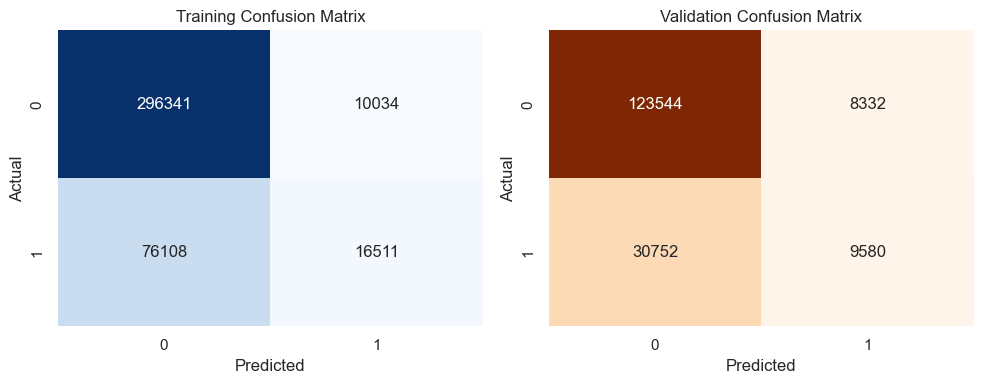

In [ ]:
# Scale features
scaler = StandardScaler()
final_features_X_val_scaled_std = scaler.transform(X_val_final)
final_features_X_train_scaled_std = scaler.fit_transform(X_train_final)
final_features_df_test_scaled_std = scaler.transform(X_test_final)

# Logistic Regression Model
log_reg_std = LogisticRegression(max_iter=1000, random_state=42)
log_reg_std.fit(final_features_X_train_scaled_std, y_train_encoded)
pred_train_log_final_std = log_reg_std.predict(final_features_X_train_scaled_std)
pred_val_log_final_std = log_reg_std.predict(final_features_X_val_scaled_std)

# Metrics for Logistic Regression
print("Logistic Regression Metrics:")
metrics(y_train_encoded, pred_train_log_final_std, y_val_encoded, pred_val_log_final_std)

### __`Min Max Scaler`__

Logistic Regression Metrics:
___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.97      0.87    306375
           1       0.62      0.18      0.28     92619

    accuracy                           0.78    398994
   macro avg       0.71      0.57      0.57    398994
weighted avg       0.76      0.78      0.73    398994

___________________________________________________________________________________________________________
                                                VALIDATION                                                 
--------------------------------------------------------------------------------------------------------

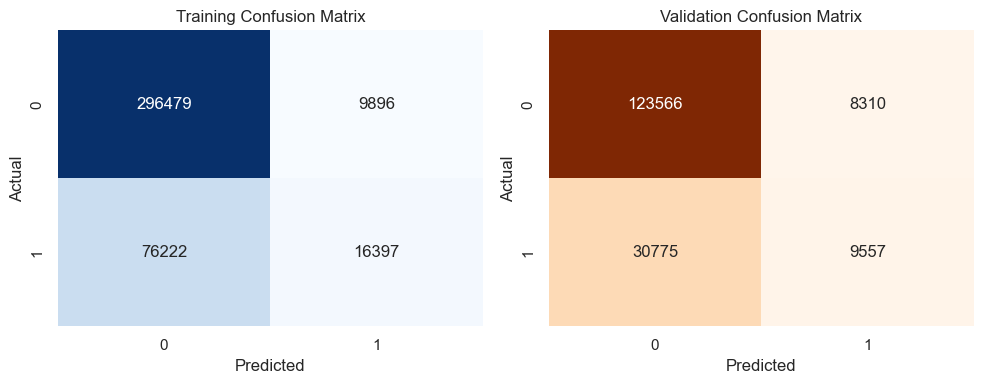

In [ ]:
# Scale features
scaler = MinMaxScaler()
final_features_X_train_scaled_minmax = scaler.fit_transform(X_train_final)
final_features_X_val_scaled_minmax = scaler.transform(X_val_final)
final_features_df_test_scaled_minmax = scaler.transform(X_test_final)

# Logistic Regression Model
log_reg_minmax = LogisticRegression(max_iter=1000, random_state=42)
log_reg_minmax.fit(final_features_X_train_scaled_minmax, y_train_encoded)
pred_train_log_final_minmax = log_reg_minmax.predict(final_features_X_train_scaled_minmax)
pred_val_log_final_minmax = log_reg_minmax.predict(final_features_X_val_scaled_minmax)

# Metrics for Logistic Regression
print("Logistic Regression Metrics:")
metrics(y_train_encoded, pred_train_log_final_minmax, y_val_encoded, pred_val_log_final_minmax)

### __`Robust Scaler`__

Logistic Regression Metrics:
___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.97      0.87    306375
           1       0.62      0.18      0.28     92619

    accuracy                           0.78    398994
   macro avg       0.71      0.57      0.58    398994
weighted avg       0.76      0.78      0.73    398994

___________________________________________________________________________________________________________
                                                VALIDATION                                                 
--------------------------------------------------------------------------------------------------------

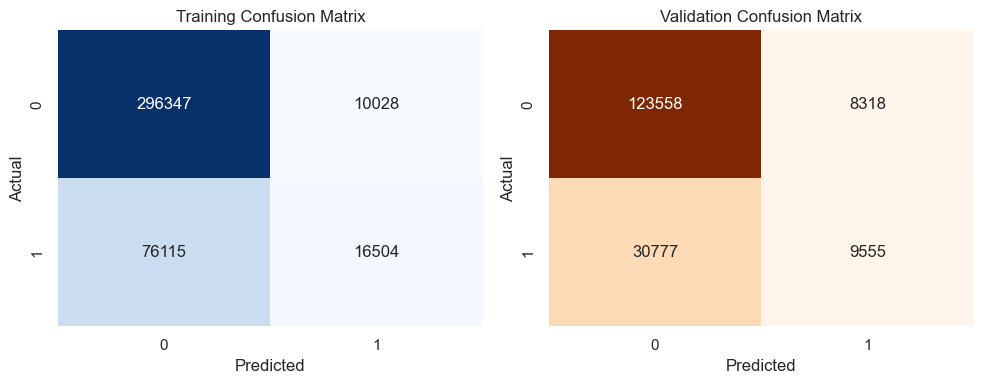

In [ ]:
# Scale features
scaler = RobustScaler()
final_features_X_train_scaled_rob = scaler.fit_transform(X_train_final)
final_features_X_val_scaled_rob = scaler.transform(X_val_final)
final_features_df_test_scaled_rob = scaler.transform(X_test_final)

# Logistic Regression Model
log_reg_rob = LogisticRegression(max_iter=1000, random_state=42)
log_reg_rob.fit(final_features_X_train_scaled_rob, y_train_encoded)
pred_train_log_final_rob = log_reg_rob.predict(final_features_X_train_scaled_rob)
pred_val_log_final_rob = log_reg_rob.predict(final_features_X_val_scaled_rob)

# Metrics for Logistic Regression
print("Logistic Regression Metrics:")
metrics(y_train_encoded, pred_train_log_final_rob, y_val_encoded, pred_val_log_final_rob)

##### Train test Split
| Model Name | Scaler | Resampling Technique | F1 Score (Train)| F1 Score (Validation)|
|------------|-------------|----------------------|------------------|-----------------------|
| Logistic Regression | Standard | None  |     0.59       |      0.61             |
| Logistic Regression | MinMax | None  |         0.59         |        0.60              | 
| Logistic Regression  | Robust | None   |          0.59      |        0.60          |  

---

## 5.2. KNN</b> <a class="anchor" id="section_5_2"></a>


### __`Standard Scaler`__


K-Nearest Neighbors Metrics:
___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.98      0.89    306375
           1       0.79      0.31      0.45     92619

    accuracy                           0.82    398994
   macro avg       0.81      0.64      0.67    398994
weighted avg       0.82      0.82      0.79    398994

___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-------------------------------------------------------------------------------------------------------

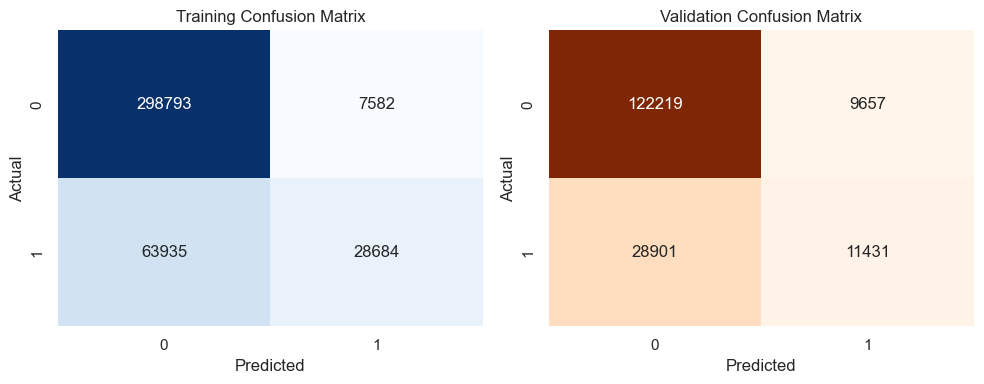

In [ ]:
# K-Nearest Neighbors Model

knn_std = KNeighborsClassifier(n_neighbors=6)
knn_std.fit(final_features_X_train_scaled_std, y_train_encoded)
pred_train_knn_final_std = knn_std.predict(final_features_X_train_scaled_std)
pred_val_knn_final_std = knn_std.predict(final_features_X_val_scaled_std)

# Metrics for K-Nearest Neighbors
print("\nK-Nearest Neighbors Metrics:")
metrics(y_train_encoded, pred_train_knn_final_std, y_val_encoded, pred_val_knn_final_std)

### __`KNN Standard Scaler CV`__

K-Nearest Neighbors Cross-Validation Scores: [0.60627145 0.6048136  0.60486893 0.60798122 0.61186465]
Mean Cross-Validation Score for K-Nearest Neighbors: 0.6071599699821182

K-Nearest Neighbors Metrics:
___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.98      0.89    306375
           1       0.79      0.31      0.45     92619

    accuracy                           0.82    398994
   macro avg       0.81      0.64      0.67    398994
weighted avg       0.82      0.82      0.79    398994

___________________________________________________________________________________________________________
                                     

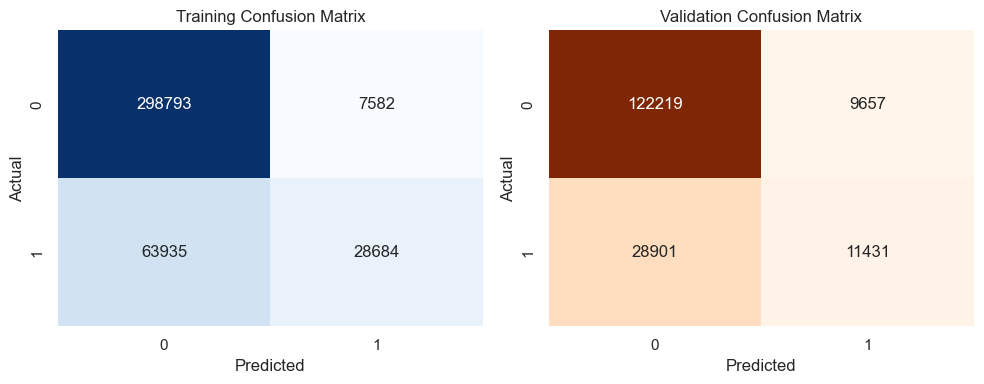

In [ ]:

# Initialize the KNN model with 6 neighbors
knn_std = KNeighborsClassifier(n_neighbors=6)

# Define K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation for KNN
cv_scores_knn = cross_val_score(knn_std, final_features_X_train_scaled_std, y_train_encoded, cv=kf, scoring='f1_macro')

# Print cross-validation results
print("K-Nearest Neighbors Cross-Validation Scores:", cv_scores_knn)
print("Mean Cross-Validation Score for K-Nearest Neighbors:", cv_scores_knn.mean())

# Fit the KNN model on the full training data after cross-validation
knn_std.fit(final_features_X_train_scaled_std, y_train_encoded)

# Calculate metrics for training and validation sets
pred_train_knn_final_std = knn_std.predict(final_features_X_train_scaled_std)
pred_val_knn_final_std = knn_std.predict(final_features_X_val_scaled_std)

# Metrics for K-Nearest Neighbors
print("\nK-Nearest Neighbors Metrics:")
metrics(y_train_encoded, pred_train_knn_final_std, y_val_encoded, pred_val_knn_final_std)

| Model Name              | Scaler | Split Method     | F1 Score (Train) | F1 Score (Validation) |
|--------------------------|------------------|------------------|------------------|-----------------------|
| KNN  | Standard | Train Test Split  |       0.68        |      0.62           |  
| KNN | Standard | Stratified K-Fold  |       0.67       |         0.57           | 

---

## 5.3. Decision Trees</b> <a class="anchor" id="section_5_3"></a>

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    202442
           1       1.00      1.00      1.00    103933
           2       1.00      1.00      1.00     92619

    accuracy                           1.00    398994
   macro avg       1.00      1.00      1.00    398994
weighted avg       1.00      1.00      1.00    398994

___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-------------------------------------------------------------------------------

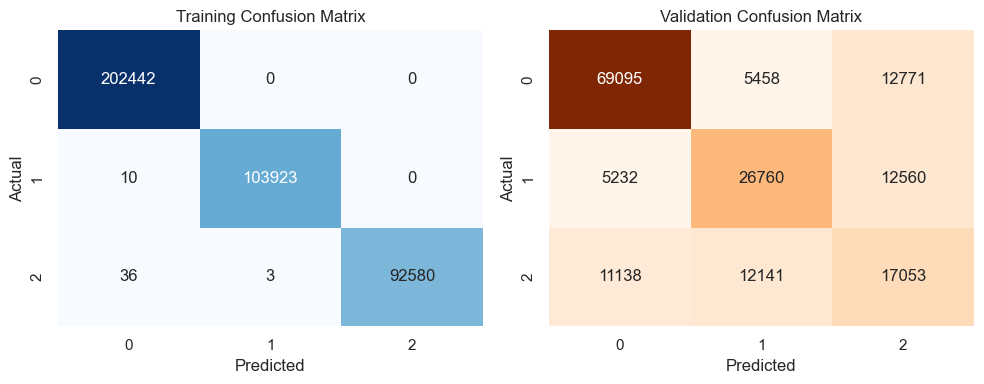

In [ ]:
# Decision Tree Model
dt_std = DecisionTreeClassifier(random_state=42)

# Fit model with final features
dt_std.fit(final_features_X_train_scaled_std, y_train_encoded)
y_pred_dt_final = dt_std.predict(final_features_X_val_scaled_std)

# Metrics for Decision Tree
dt_std.fit(final_features_X_train_scaled_std, y_train_encoded)
pred_train_dt_final_std = dt_std.predict(final_features_X_train_scaled_std)
pred_val_dt_final_std = dt_std.predict(final_features_X_val_scaled_std)
metrics(y_train_encoded, pred_train_dt_final_std, y_val_encoded, pred_val_dt_final_std)

Fit Decision Tree model with pruning parameters for final features and potential value features since we have overfitting

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.74      0.93      0.82    202442
           1       0.58      0.57      0.58    103933
           2       0.58      0.25      0.35     92619

    accuracy                           0.68    398994
   macro avg       0.63      0.59      0.58    398994
weighted avg       0.66      0.68      0.65    398994

___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-------------------------------------------------------------------------------

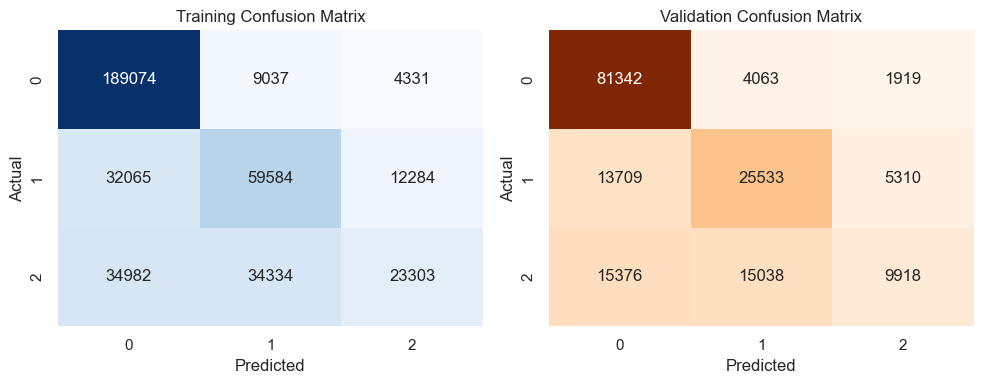

In [ ]:
# Pruned Decision Tree Classifier
pruned_dt_std = DecisionTreeClassifier(random_state=42, max_depth=5, min_samples_split =150, min_samples_leaf=150)

# Fit pruned Decision Tree model with final features and calculate metrics for training and validation
pruned_dt_std.fit(final_features_X_train_scaled_std, y_train_encoded)
pred_train_pruned_dt_std = pruned_dt_std.predict(final_features_X_train_scaled_std)
pred_val_pruned_dt_std = pruned_dt_std.predict(final_features_X_val_scaled_std)
metrics(y_train_encoded, pred_train_pruned_dt_std, y_val_encoded, pred_val_pruned_dt_std)

| Model Name | Scaler | Resampling Technique | F1 Score (Train)| F1 Score (Validation)|
|------------|-------------|----------------------|------------------|-----------------------|
| Decision Tree  | Standard | None  |        1     |        0.6       |
| Pruned Decision Tree | Standard | None  |       0.58       |       0.58             |

---

## 5.4. Random Forest</b> <a class="anchor" id="section_5_4"></a>

Cross-validation scores: [0.57655466 0.579033   0.57530949 0.57583797 0.57608185]
Mean cross-validation score: 0.5765633933696186
___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.70      0.96      0.81    202442
           1       0.63      0.55      0.58    103933
           2       0.69      0.22      0.34     92619

    accuracy                           0.68    398994
   macro avg       0.67      0.58      0.58    398994
weighted avg       0.68      0.68      0.64    398994

___________________________________________________________________________________________________________
                                                VALIDATIO

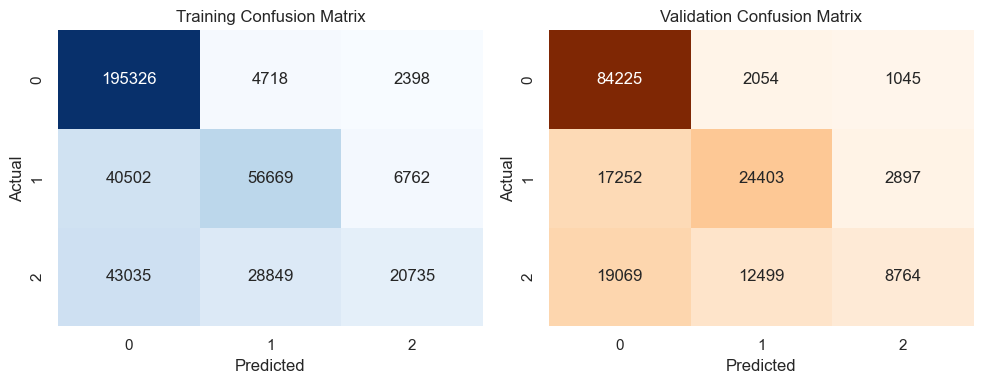

In [ ]:

# Initialize the Random Forest model
rf_std = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

# Define K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(rf_std, final_features_X_train_scaled_std, y_train_encoded, cv=kf, scoring='f1_macro')

# Print cross-validation results
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

# After cross-validation, fit the model on the full training data
rf_std.fit(final_features_X_train_scaled_std, y_train_encoded)

# Calculate metrics for training and validation sets
pred_train_rf_std = rf_std.predict(final_features_X_train_scaled_std)
pred_val_rf_std = rf_std.predict(final_features_X_val_scaled_std)
metrics(y_train_encoded, pred_train_rf_std, y_val_encoded, pred_val_rf_std)


___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.70      0.96      0.81    202442
           1       0.63      0.55      0.58    103933
           2       0.69      0.22      0.34     92619

    accuracy                           0.68    398994
   macro avg       0.67      0.58      0.58    398994
weighted avg       0.68      0.68      0.64    398994

___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-------------------------------------------------------------------------------

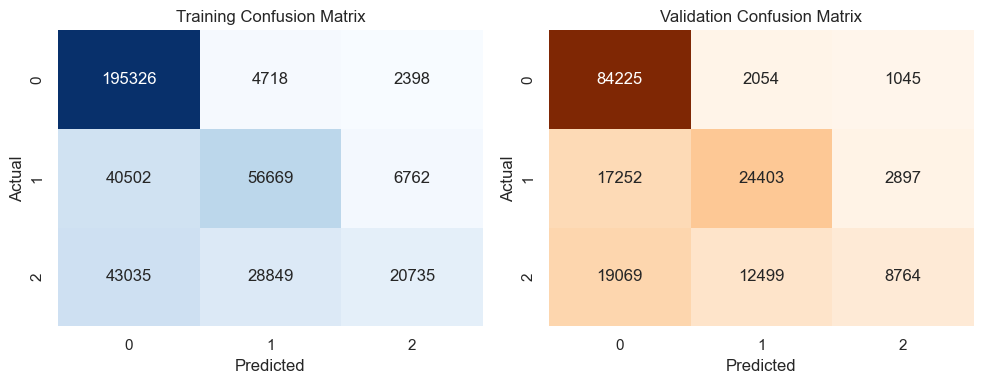

In [ ]:
# Random Forest Classifier
rf_std = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

# Fit Random Forest model with final features and calculate metrics for training and validation
rf_std.fit(final_features_X_train_scaled_std, y_train_encoded)
pred_train_rf_std= rf_std.predict(final_features_X_train_scaled_std)
pred_val_rf_std = rf_std.predict(final_features_X_val_scaled_std)
metrics(y_train_encoded, pred_train_rf_std, y_val_encoded, pred_val_rf_std)

| Model Name | Scaler | Split Method | F1 Score (Train)| F1 Score (Validation)| 
|------------|-------------|----------------------|------------------|-----------------------|
| Random Forest  | Standard | Cross Validation  |     0.58        |        0.58    |
| Random Forest  | Standard | Train Test Split  |      0.58      |     0.58        |


---

## 5.5. Ensemble Methods </b> <a class="anchor" id="section_5_5"></a>

 ### 5.5.1. Boosting <a class="anchor" id="sub_section_5_5_1"></a>

> ### Gradient Boosting

#### __`XGBClassifier`__

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.96      0.89    202442
           1       0.73      0.74      0.74    103933
           2       0.65      0.39      0.49     92619

    accuracy                           0.77    398994
   macro avg       0.74      0.70      0.70    398994
weighted avg       0.76      0.77      0.76    398994

___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-------------------------------------------------------------------------------

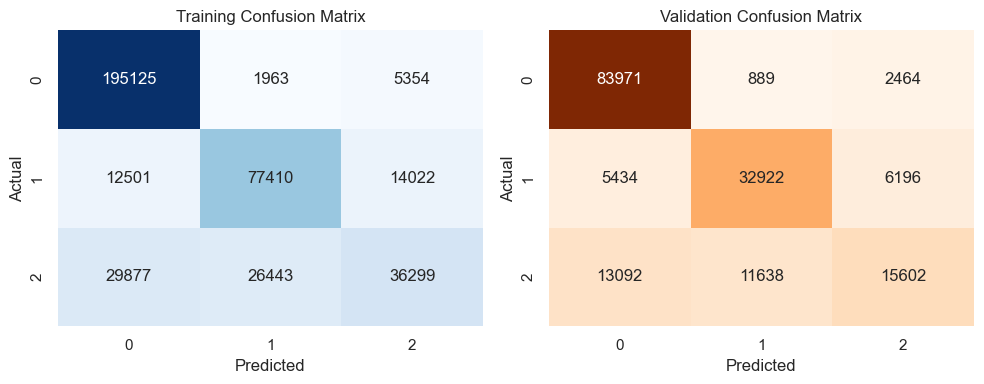

In [ ]:
# XGBoost Classifier
xgb_std = XGBClassifier(n_estimators=100, max_depth=5, random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# Fit XGBoost model with final features and calculate metrics for training and validation
xgb_std.fit(final_features_X_train_scaled_std, y_train_encoded)
pred_train_xgb_std = xgb_std.predict(final_features_X_train_scaled_std)
pred_val_xgb_std = xgb_std.predict(final_features_X_val_scaled_std)

metrics(y_train_encoded, pred_train_xgb_std, y_val_encoded, pred_val_xgb_std)

#### __`CatBoost (CatBoostClassifier)`__ <br>
CatBoost is a gradient boosting framework designed to natively support categorical features. It is efficient, easy to implement, and often performs well on tabular data.

In [ ]:
# Scale numerical features (CatBoost does not require scaling, but we'll keep it for consistency)
scaler = StandardScaler()
final_features_X_train_scaled_std = scaler.fit_transform(X_train_final)
final_features_X_val_scaled_std = scaler.transform(X_val_final)
final_features_df_test_scaled_std = scaler.transform(X_test_final)

# Initialize CatBoost
catboost_model = CatBoostClassifier(
    iterations=100,                # Number of boosting iterations
    learning_rate=0.1,             # Step size for gradient descent
    depth=6,                       # Depth of the tree
    random_seed=42,                # Random seed for reproducibility
    eval_metric='F1',              # Metric for evaluation
    verbose=10,                    # Display training progress every 10 iterations
    # No need to specify cat_features since all features are numeric
)

# Train the CatBoost model
catboost_model.fit(
    final_features_X_train_scaled_std, y_train_encoded,
    eval_set=(final_features_X_val_scaled_std, y_val_encoded),  # Validation set for monitoring
    use_best_model=True,  # Save the best iteration during training
    plot=False            # Set to True if you want a training plot
)

# Make predictions
train_preds = catboost_model.predict(final_features_X_train_scaled_std)
val_preds = catboost_model.predict(final_features_X_val_scaled_std)

# Evaluate using F1 Macro score
f1_train = f1_score(y_train_encoded, train_preds, average='macro')
f1_val = f1_score(y_val_encoded, val_preds, average='macro')

# Print F1 Macro scores
print(f"CatBoost F1 Macro - Train: {f1_train:.4f}, Validation: {f1_val:.4f}")

# Uncomment to make predictions on the test dataset
# test_preds = catboost_model.predict(final_features_df_test_scaled_std)

# Uncomment to save the predictions to a CSV file
# test_predictions_df = pd.DataFrame(test_preds, columns=['Predictions'])
# test_predictions_df.to_csv('catboost_test_predictions.csv', index=False)
# print("Test predictions saved to 'catboost_test_predictions.csv'.")


0:	learn: 0.2754898	test: 0.2733397	best: 0.2733397 (0)	total: 74.7ms	remaining: 7.4s
10:	learn: 0.3182064	test: 0.3572314	best: 0.3579237 (9)	total: 237ms	remaining: 1.92s
20:	learn: 0.3352682	test: 0.3849356	best: 0.3856532 (18)	total: 404ms	remaining: 1.52s
30:	learn: 0.3503540	test: 0.3992387	best: 0.3992387 (30)	total: 569ms	remaining: 1.26s
40:	learn: 0.3679557	test: 0.4165661	best: 0.4165661 (40)	total: 739ms	remaining: 1.06s
50:	learn: 0.3764798	test: 0.4243475	best: 0.4243475 (50)	total: 910ms	remaining: 875ms
60:	learn: 0.3846912	test: 0.4295739	best: 0.4295940 (59)	total: 1.08s	remaining: 692ms
70:	learn: 0.3907044	test: 0.4361517	best: 0.4361517 (70)	total: 1.25s	remaining: 510ms
80:	learn: 0.3971834	test: 0.4413268	best: 0.4413268 (80)	total: 1.42s	remaining: 334ms
90:	learn: 0.4028916	test: 0.4453317	best: 0.4453317 (90)	total: 1.59s	remaining: 157ms
99:	learn: 0.4069471	test: 0.4509122	best: 0.4509122 (99)	total: 1.74s	remaining: 0us

bestTest = 0.4509122235
bestIteratio

#### __`HyperTuning XgBoost`__ <br>

In [ ]:
# Scale features (optional step, XGBoost handles unscaled features well)
scaler = StandardScaler()
final_features_X_train_scaled_std = scaler.fit_transform(X_train_final)
final_features_X_val_scaled_std = scaler.transform(X_val_final)
final_features_df_test_scaled_std = scaler.transform(X_test_final)

# Define the XGBoost model
xgb = XGBClassifier(random_state=42)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, 
                           scoring='f1_macro', cv=3, verbose=2, n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(final_features_X_train_scaled_std, y_train_encoded)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best parameters and the best F1 Macro score
print(f"Best parameters found: {best_params}")
print(f"Best F1 Macro score from GridSearchCV: {best_score:.4f}")

# Retrain the best model on the full training set
best_xgb_model = grid_search.best_estimator_

# Make predictions on the validation set
val_preds = best_xgb_model.predict(final_features_X_val_scaled_std)

# Evaluate the best model using F1 Macro score
f1_val = f1_score(y_val_encoded, val_preds, average='macro')

# Print F1 Macro score on validation set
print(f"Best XGBoost F1 Macro - Validation: {f1_val:.4f}")

Fitting 3 folds for each of 324 candidates, totalling 972 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, subsample=1.0; total time=   2.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.8; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=100, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=200, subsample=1.0; total time=   2.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, subsample=1.0; total time=   4.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=200, subsample=1.0; tota

In [ ]:
# Make predictions on the test dataset
test_preds = best_xgb_model.predict(final_features_df_test_scaled_std)

# Add the predictions as a new column to the original test dataframe
df_test_with_preds = pd.read_csv('/Users/goncaloperes/Documents/ML Project/Data_Temporary/df_test_processed.csv')  # Load the original test dataset
df_test_with_preds['Predictions'] = test_preds  # Add the predictions as a new column

# Save the entire test dataset with the predictions column
df_test_with_preds.to_csv('/Users/goncaloperes/Documents/ML Project/Data_Temporary/best_xgb_test_predictions.csv', index=False)
print("Test predictions saved to 'best_xgb_test_predictions.csv'.")


Test predictions saved to 'best_xgb_test_predictions.csv'.


> ### AdaBoost

In [ ]:
# Scale features
scaler = StandardScaler()
final_features_X_train_scaled_std = scaler.fit_transform(X_train_final)
final_features_X_val_scaled_std = scaler.transform(X_val_final)
final_features_df_test_scaled_std = scaler.transform(X_test_final)

# Initialize AdaBoost with a DecisionTreeClassifier as the base estimator
base_estimator = DecisionTreeClassifier(max_depth=1, random_state=42)  # Weak learner
adaboost = AdaBoostClassifier(estimator=base_estimator, n_estimators=100, random_state=42)

# Train the AdaBoost model
adaboost.fit(final_features_X_train_scaled_std, y_train_encoded)

# Make predictions
train_preds = adaboost.predict(final_features_X_train_scaled_std)
val_preds = adaboost.predict(final_features_X_val_scaled_std)

# Evaluate using F1 Macro score
f1_train = f1_score(y_train_encoded, train_preds, average='macro')
f1_val = f1_score(y_val_encoded, val_preds, average='macro')

# Print F1 Macro scores
print(f"AdaBoost F1 Macro - Train: {f1_train:.4f}, Validation: {f1_val:.4f}")

# Uncomment to make predictions on the test dataset
# test_preds = adaboost.predict(final_features_df_test_scaled_std)

# Uncomment to save the predictions to a CSV file
# test_predictions_df = pd.DataFrame(test_preds, columns=['Predictions'])
# test_predictions_df.to_csv('adaboost_test_predictions.csv', index=False)
# print("Test predictions saved to 'adaboost_test_predictions.csv'.")


AdaBoost F1 Macro - Train: 0.6098, Validation: 0.6161


---

In [ ]:
# Scale features
scaler = StandardScaler()
final_features_X_train_scaled_std = scaler.fit_transform(X_train_final)
final_features_X_val_scaled_std = scaler.transform(X_val_final)
final_features_df_test_scaled_std = scaler.transform(X_test_final)

# Initialize the models
rf = RandomForestClassifier(n_estimators=100, random_state=42)
xgb = XGBClassifier(n_estimators=100, random_state=42)

# Create a VotingClassifier (ensemble)
ensemble = VotingClassifier(estimators=[('rf', rf), ('xgb', xgb)], voting='hard')  # For hard voting

# Train the individual models
rf.fit(final_features_X_train_scaled_std, y_train_encoded)
xgb.fit(final_features_X_train_scaled_std, y_train_encoded)

# Train the ensemble model
ensemble.fit(final_features_X_train_scaled_std, y_train_encoded)

# Make predictions on the validation set
rf_train_preds = rf.predict(final_features_X_train_scaled_std)
rf_val_preds = rf.predict(final_features_X_val_scaled_std)

xgb_train_preds = xgb.predict(final_features_X_train_scaled_std)
xgb_val_preds = xgb.predict(final_features_X_val_scaled_std)

ensemble_train_preds = ensemble.predict(final_features_X_train_scaled_std)
ensemble_val_preds = ensemble.predict(final_features_X_val_scaled_std)

# Calculate F1 Macro score
rf_f1_train = f1_score(y_train_encoded, rf_train_preds, average='macro')
rf_f1_val = f1_score(y_val_encoded, rf_val_preds, average='macro')

xgb_f1_train = f1_score(y_train_encoded, xgb_train_preds, average='macro')
xgb_f1_val = f1_score(y_val_encoded, xgb_val_preds, average='macro')

ensemble_f1_train = f1_score(y_train_encoded, ensemble_train_preds, average='macro')
ensemble_f1_val = f1_score(y_val_encoded, ensemble_val_preds, average='macro')

# Print the F1 Macro scores
print(f"Random Forest F1 Macro - Train: {rf_f1_train:.4f}, Validation: {rf_f1_val:.4f}")
print(f"XGBoost F1 Macro - Train: {xgb_f1_train:.4f}, Validation: {xgb_f1_val:.4f}")
print(f"Ensemble F1 Macro - Train: {ensemble_f1_train:.4f}, Validation: {ensemble_f1_val:.4f}")

# Uncomment the following block if predictions on the test dataset are required
# Make predictions on the test dataset
# test_preds = ensemble.predict(final_features_df_test_scaled_std)

# Save the predictions to a CSV file
# test_predictions_df = pd.DataFrame(test_preds, columns=['Predictions'])
# test_predictions_df.to_csv('test_predictions.csv', index=False)
# print("Test predictions saved to 'test_predictions.csv'.")


Random Forest F1 Macro - Train: 0.9999, Validation: 0.6690
XGBoost F1 Macro - Train: 0.6846, Validation: 0.6811
Ensemble F1 Macro - Train: 0.7194, Validation: 0.6585


> ## XGBoost

| Model Name | Scaler | Split Method | F1 Score (Train)| F1 Score (Validation)| 
|------------|-------------|----------------------|------------------|-----------------------|
| XGBoost | Standard | Train Test Split  |        0.70     |    0.70         |

 ### 5.5.2. Bagging <a class="anchor" id="sub_section_5_5_2"></a>

In [125]:
from sklearn.model_selection import RepeatedStratifiedKFold

In [127]:
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)

In [129]:
def return_f1score(model, X, y):
    n_scores = cross_val_score(model, X, y, scoring = 'f1', cv = cv)
    return n_scores

In [131]:
def return_results(models):
    results, names = [],[]
    for name, model in models.items():
        scores = return_f1score(model, final_features_X_train_scaled_std, y_train_encoded)
        results.append(scores)
        names.append(name)
        print('>%s %.3f (%.3f)' % (name, scores.mean(), scores.std()))
    
    plt.figure(figsize=(15,7))
    plt.boxplot(results, labels = names, showmeans = True)
    plt.xticks(fontsize=14)
    plt.show()

In [133]:
print(final_features_X_train_scaled_std)

[[-0.4643635  -1.28694053 -0.91620662 ... -0.12464692 -0.33203944
  -1.46262286]
 [-0.4643635   1.27516449  1.68106477 ... -0.0456196   0.08618278
  -0.534391  ]
 [-0.4643635  -0.35950974 -0.72848024 ... -0.14823734  2.20743602
  -0.14762773]
 ...
 [-0.4643635  -0.76008823 -0.67862504 ...  0.86759218 -0.33203944
   1.0126621 ]
 [-0.4643635   1.38215984 -0.93971858 ... -0.151514   -0.33203944
  -0.22498038]
 [-0.4643635   1.04864279  1.68106477 ...  0.02623019 -0.33203944
  -0.99850693]]


>DecisionTreeClassifier() 0.406 (0.004)
>DecisionTreeClassifier()_bagging 0.407 (0.005)
>KNeighborsClassifier() 0.392 (0.004)
>KNeighborsClassifier()_bagging 0.389 (0.004)


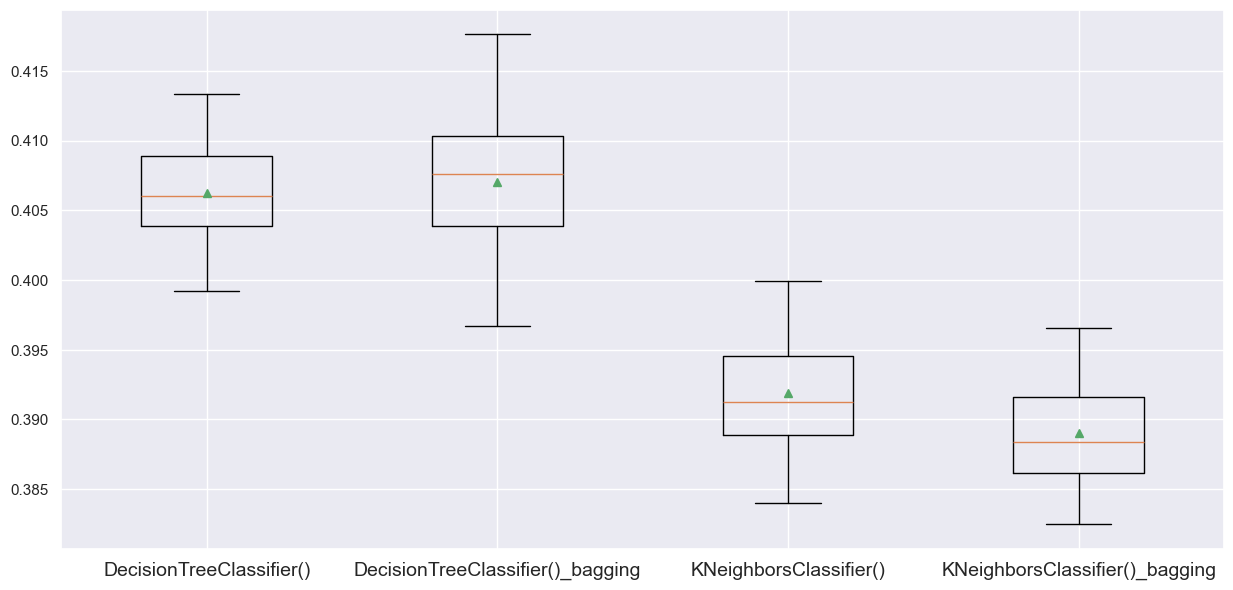

In [135]:
dt = DecisionTreeClassifier()
knn = KNeighborsClassifier()

def get_models(*args):
    models = dict()
    for arg in args:
        models[str(arg)] = arg
        models[str(arg) + '_bagging'] = BaggingClassifier(estimator = arg, random_state = 15)      
    return models

models = get_models(dt, knn)
return_results(models)

---

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import ParameterGrid

# Define base classifiers
dt = DecisionTreeClassifier()
knn = KNeighborsClassifier()

def get_models(*args):
    """Generates models with BaggingClassifier using different parameter combinations."""
    models = dict()
    
    # Define parameters to be tested in BaggingClassifier
    param_grid = {
        'n_estimators': [10, 50, 100],
        'max_samples': [0.5, 0.7, 1.0],
        'max_features': [0.5, 0.7, 1.0],
        'bootstrap': [True, False],
        'bootstrap_features': [True, False],
        'oob_score': [True, False]
    }
    
    # Generate parameter combinations
    grid = list(ParameterGrid(param_grid))

    for arg in args:
        # Add the base model
        models[str(arg)] = arg
        
        # Add models with BaggingClassifier for each parameter combination
        for i, params in enumerate(grid):
            # Only set oob_score=True if bootstrap is also True
            if params['oob_score'] and not params['bootstrap']:
                continue
            
            bagging_model = BaggingClassifier(
                estimator=arg,
                n_estimators=params['n_estimators'],
                max_samples=params['max_samples'],
                max_features=params['max_features'],
                bootstrap=params['bootstrap'],
                bootstrap_features=params['bootstrap_features'],
                oob_score=params['oob_score'],
                random_state=15
            )
            model_name = f"{str(arg)}bagging{i}"
            models[model_name] = bagging_model

    return models

def return_results(models):
    """Simulates returning results (you can adjust to train and evaluate models)."""
    for name, model in models.items():
        print(f"Model: {name} -> {model}")

# Generate models and display results
models = get_models(dt, knn)
return_results(models)

# 6. Loading the Results <a class="anchor" id="chapter6"></a>